# Implementation of Text analytics and Recommendation systems on YELP Dataset



## Team 8: Jayanth Chava, Ashwin George and Suraj Ghule

# Problem Statement

Our goal is to build a model that predicts whether a review has a positive or negative impact on a certain establishment. We have 3.53GB dataset on yelp reviews, which we intend to analyze closely and develop an algorithm for auto summarization which will give us a few lines overview of an establishment.

Using user review data from Yelp, we want to develop a recommendation system to provide a new restaurant suggestion that a user might like. The project was motivated by the fact that recommendation problems are ubiquitious, including the infamous Netflix challenge and "similar items you might like" suggestions from Amazon. Given the diverse application of this problem, we wanted to learn how to develop and implement such system using machine learning. Below, we graphically illustrate our project goal.



# Introduction and description of data

<center>
<img src = /notebooks/images.ipynb/datasetoverview.png width = 900 />
</center>
Image credit: Yelp

The Yelp data is vast and rich: it contains millions of reviews of different business types (e.g. restaurants and dry cleaners), and each business type has different set of attributes associated with them. Each review at minimum consists of review text and review star rating. Because of its size and richness, it presented an initial challenge for us to decide what data to include in our modeling and what features should be engineered. In addition, not every user has made several reviews or reviews with different ratings, so we needed to figure out what datasets to use for training vs. testing. To this end, we performed EDA on the data, specifically to look at relevant business attributes, user attributes, and reviews. We reasoned that these are the core information needed to link users and businesses with their preferences (hence, we disregarded data such as checkin, photos, and tip). 

<center>
<img src = /notebooks/images.ipynb/projectgoal.png width = 900 />
</center>

# Importing the necessary libraries:
These libraries are the most important libraries that we will be need: 
1. Numpy : NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.
2. Pandas : Pandas is a software library written for the Python programming language for data manipulation and analysis. In particular, it offers data structures and operations for manipulating numerical tables and time series.
3. Matplotlib : Matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy.
4. NLTK : NLTK is a suite of libraries and programs for symbolic and statistical natural language processing (NLP) for English written in the Python programming language. 
5. Scikit-learn : Scikit-learn is a machine learning library for the Python programming language. It features various classification, regression and clustering algorithms including support vector machines, random forests, gradient boosting, k-means and DBSCAN.
6. Wordcloud : Wordcloud is a library for visual representation of text data, typically used to depict keyword metadata (tags) on websites, or to visualize free form text.
    
We shall be loading all the above libraries and several of their features which we will be using in this program.


Lets import required packages and load data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import collections
import re, string
import sys
import time
from wordcloud import WordCloud
#from mpl_toolkits.basemap import basemap

from subprocess import check_output

%matplotlib inline


import nltk
import string

import re
import time
import json
from itertools import compress
from sklearn.model_selection import train_test_split


import nltk
from nltk.corpus import stopwords
from nltk import ngrams

**JSON to CSV**

We found a function "json_to_csv" which reads the JSON files from the drive and converts it into a csv file. we also have the option of creating a sample csv if required.Since all our data was in JSON format this function was useful for converting it to csv for analysis.  

In [2]:
def json_to_csv(directory, fileNames, createSample=False):
    
    #json_to_csv: loops through specified JSON files and converts them to csv files.
    #option to also create a sample csv, which uses np.random.seed 9001 to create a sample dataset with 10% of the observations
    #pandas has a read_json function, but returns a 'Trailing data error' when working with these specific files
    #Inputs: -directory of JSON files
    #        -list of JSON filenames
    #         -createSample flag
    
    
    start = time.time()

    jsonData = []

    for fileName in fileNames:
        with open(directory + fileName,  encoding="utf8") as file:
            print('{0} opened'.format(fileName))
            for line in file:
                #I use an rstrip here because some of the files have trailing blank spaces
                jsonData.append(json.loads(line.rstrip()))
        
        df = pd.DataFrame.from_dict(jsonData)
        
        csvFileName = fileName[:len(fileName)-5] + '.csv'
        
        df.to_csv(directory + csvFileName)
        print('{0} created'.format(csvFileName))
        
        
        if createSample:
            np.random.seed(9001)
            msk = np.random.rand(len(df)) <= 0.1
            sample = df[msk]
            
            csvSampleFileName = fileName[:len(fileName)-5] + '_sample.csv'
            
            sample.to_csv(directory + csvSampleFileName)
            print('{0} created'.format(csvSampleFileName))
        
    print('This function took {} minutes to run'.format((time.time()-start)/60))

We Convert 3 JSON files Yelp's Business,User and Review for the analysis.
And also read a Yelp_Tip file which is already in csv format.

In [3]:
fileNameList = ['user.json']

json_to_csv('C:/YELP/', fileNameList, createSample=True)

user.json opened
user.csv created
user_sample.csv created
This function took 1.6888779083887735 minutes to run


In [4]:
fileNameList = ['business.json']

json_to_csv('C:/YELP/', fileNameList, createSample=True)

business.json opened
business.csv created
business_sample.csv created
This function took 0.16883023182551066 minutes to run


In [5]:
fileNameList = ['review.json']

json_to_csv('C:/YELP/', fileNameList, createSample=True)

review.json opened
review.csv created
review_sample.csv created
This function took 3.6351562619209288 minutes to run


In [6]:
yelp_tips = pd.read_csv("C:/yelp_tip.csv")
yelp_review = pd.read_csv("C:/yelp_ review.csv")
yelp_business = pd.read_csv("C:/yelp_business.csv")
yelp_review["date"] =  pd.to_datetime(yelp_review["date"], format='%Y-%m-%d')
yelp_review['year'] = yelp_review.date.dt.year

In [7]:
yelp_users = pd.read_csv("C:/yelp_user.csv")

Lets see how data looks like

In [8]:
yelp_review.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,year
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0,2016
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0,2016
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0,2016
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0,2016
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0,2016


In [9]:
yelp_business.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


In [10]:
yelp_users.head()

,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,JJ-aSuM4pCFPdkfoZ34q0Q,Chris,10,2013-09-24,"0njfJmB-7n84DlIgUByCNw, rFn3Xe3RqHxRSxWOU19Gpg...",0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
1,uUzsFQn_6cXDh6rPNGbIFA,Tiffy,1,2017-03-02,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
2,mBneaEEH5EMyxaVyqS-72A,Mark,6,2015-03-13,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
3,W5mJGs-dcDWRGEhAzUYtoA,Evelyn,3,2016-09-08,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
4,4E8--zUZO1Rr1IBK4_83fg,Lisa,11,2012-07-16,None,4,0,0,0,None,...,0,0,0,0,0,0,0,0,1,0


Lets get the overview of reviews.

1.Top reviewed business : Business with most numbers of positive reviews

2.Negatively reviewed business : Business with most numbers of negative reviews
3.Trending business : Business with most number of reviews, with more than 4 stars in recent years

4.Positive review : Review with more than 3 stars

5.Negative review : Review with just 1 star

In [162]:
useful_reviews = len(yelp_review[yelp_review["useful"]>0])#checkin reviews for the occurence of the term "useful"
cool_reviews = len(yelp_review[yelp_review["cool"]>0])#checkin reviews for the occurence of the term "cool"
funny_reviews = len(yelp_review[yelp_review["funny"]>0])#checkin reviews for the occurence of the term "funny"
negative_reviws = len(yelp_review[yelp_review["stars"]<2])#calculating all the negative reviews with respect to the number of stars
positive_reviews =len(yelp_review[yelp_review["stars"]>3])#calculating all the positive reviews with respect to the number of stars
total_reviews = len(yelp_review)

print("Total reviews: {}".format(total_reviews))
print("Useful reviews: {}".format(useful_reviews))
print("Funny reviews: {}".format(funny_reviews))
print("Cool reviews: {}".format(cool_reviews))
print("Total negative reviews: {}".format(negative_reviws))
print("Total positive reviews: {}".format(positive_reviews))


Total reviews: 5261668
Useful reviews: 2517186
Funny reviews: 1130906
Cool reviews: 1366594
Total negative reviews: 731363
Total positive reviews: 3476663


We create a small function to define a basic sentiment of a review based on the stars given by the user.  If stars are less than 2 then we consider it to be a Negitive, else Positive.

In [12]:
# calculating sentiment of each establishment based on the number of stars 
yelp_review["Sentiment"] = yelp_review["stars"].apply(lambda stars: "positive" if stars > 2 else "negative")

In [17]:
yelp_review.tail(1)

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,year,Sentiment
5261667,ldsIs3sGXPJ7WM7VyAm4lQ,mPjPyipaD0C_myqWqDipZg,HloEEXm_QzEpycuwA_RtQA,3,2011-11-15,Really nice atmosphere and settings and very c...,0,1,1,2011,positive


In [18]:
%%time
top_reviewed = yelp_review[yelp_review["stars"]>3] #only considering the businesses which have more than 3 stars
top_reviews_dict ={}

for business_id in top_reviewed["business_id"].values:
    try :
        top_reviews_dict[business_id] =top_reviews_dict[business_id]+1
    except:
        top_reviews_dict[business_id]=1
        
topbusiness = pd.DataFrame.from_dict(data= top_reviews_dict,orient="index")

topbusiness.reset_index(inplace=True)
topbusiness.columns = ['business_id', 'rated']
print(topbusiness)
# all the highly rated business are displayed below

                   business_id  rated
0       AEx2SYEUJmTxVVB18LlCwA     68
1       VR6GpWIda3SfvPC-lg9H3w     44
2       CKC0-MOWMqoeWf6s-szl8g     54
3       ACFtxLv8pGrrxMm6EgjreA     38
4       s2I_Ni76bjJNK9yG60iD-Q    335
5       8QWPlVQ6D-OExqXoaD2Z1g     35
6       9_CGhHMz8698M9-PkVf0CQ     86
7       gkCorLgPyQLsptTHalL61g     52
8       fDF_o2JPU8BR1Gya--jRIA      3
9       z8oIoCT1cXz7gZP5GeU5OA     18
10      Aov96CM4FZAXeZvKtsStdA     38
11      0W4lkclzZThpx3V65bVgig   1486
12      RWGI8u00x5GghYCEzpYrIg    109
13      tOhRQqiupLyJdBJVQMGOEQ    394
14      AIUFSIIdCEi3XoRJaxtDLQ     23
15      4_GIJk0tX3k0x0FcUv4sNA     26
16      a9aW5e731lplWGHUZ02-zQ    121
17      3E5umUqaU5OZAV3jNLW3kQ      5
18      0-yj2jtzLUHG2b7PpEHyog     58
19      N-11FCEppz5NVYZVM2G5yA      3
20      2QCZyAOB6xXKCdyFPvXXmw     38
21      Tn8O4tv1U-n0PRC8kbJJPg    122
22      vyeQzjZFx6KoL2pJBQ2QFA     26
23      D2PmpZYRdRnzL7q4Wprf3Q     13
24      BmSLyxm8b86dtzwuT7LqBA     43
25      KpFc

# Top reviewed business
We have taken the Top reviewed business , with more than 3 stars and checked the number of times it has been rated with 4 or 5 stars.

In [19]:
# sorting all the top business
top_count= 20
right=pd.DataFrame(yelp_business[['business_id',"name","categories"]].values,
                    columns=['business_id',"Business_name","categories"])

top_business_data = pd.merge(topbusiness,right=right, how="inner",on='business_id')
top_business_data = top_business_data.sort_values("rated")[::-1][:top_count]
print(top_business_data)
len(top_business_data)

                  business_id  rated                    Business_name  \
1005   4JNXUYY8wbaaDmk3BPzlWw   5856                   "Mon Ami Gabi"   
2764   RESDUcs7fIiihp38-d6_6g   4624               "Bacchanal Buffet"   
2813   DkYS3arLOhA8si5uUEmHOw   4060               "Earl of Sandwich"   
5824   cYwJA2A6I12KNkm2rtXd5g   3780            "Gordon Ramsay BurGR"   
1147   K7lWdNUhCbcnEvI0NhGewg   3757                   "Wicked Spoon"   
209    f4x1YBxkLrZg652xt2KR5g   3404             "Hash House A Go Go"   
4542   KskYqH1Bi7Z_61pH6Om8pg   3194                  "Lotus of Siam"   
2008   iCQpiavjjPzJ5_3gPD5Ebg   2982                   "Secret Pizza"   
1640   hihud--QRriCYZw1zZvW4g   2973       "Gangnam Asian BBQ Dining"   
2578   5LNZ67Yw9RD6nf4_UhXOjw   2722  "The Cosmopolitan of Las Vegas"   
665    rcaPajgKOJC2vo_l3xa42A   2639   "Bouchon at the Venezia Tower"   
2040   2weQS-RnoOBhb1KsHKyoSQ   2443                     "The Buffet"   
663    Wxxvi3LZbHNIDwJ-ZimtnA   2330         "The V

20

Now we take out the required columns for top 20 business which have been rated with 4 or 5 stars most number of times.     

Text(0,0.5,'Total ratings')

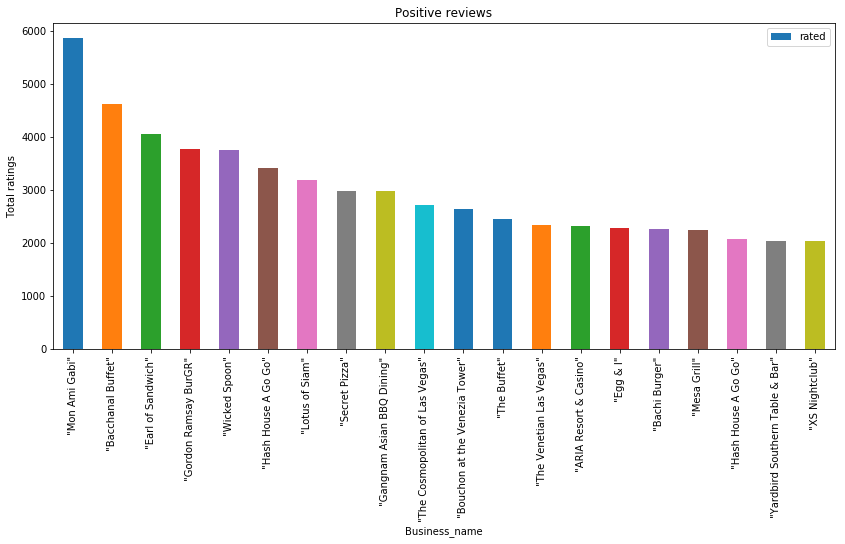

In [20]:
top_business_data.plot(x="Business_name",y="rated", kind="bar",figsize=(14,6),title='Positive reviews').set_ylabel("Total ratings") 

# How businesses are getting reviewed over time


Some businesses try to maintain their overall quality standards and make their customers happy. Lets see which businesses are maintaining their quality standards  based on positive reviews.

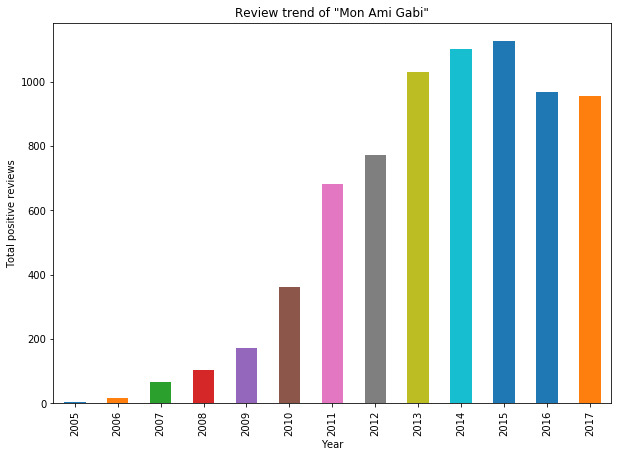

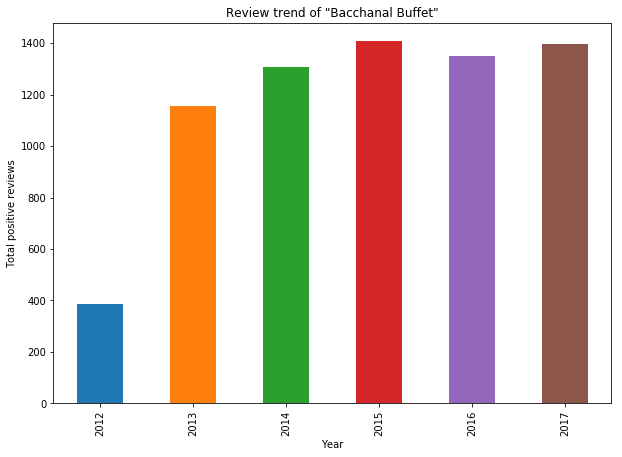

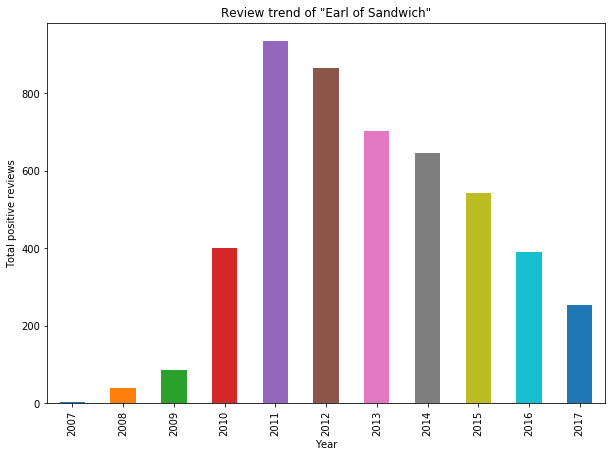

In [22]:
num_business = 3 #this parameter can be changed to see the trends of how many ever top business as we want
business_ids = top_business_data.sort_values("rated")[::-1][:num_business].business_id.values
business_names = top_business_data.sort_values("rated")[::-1][:num_business]["Business_name"].values
for i, business_id in enumerate(business_ids):
    useful_b = yelp_review.loc[yelp_review['business_id'] == business_id]
    useful_b = useful_b.groupby(['year']).size().reset_index(name='counts')
    #print(useful_b.head())
    series = pd.Series(useful_b["counts"].values, index=useful_b["year"].values, name='Review trend')
    axes = series.plot(kind="bar",figsize=(10, 7))
    plt.xlabel('Year', axes=axes)
    plt.ylabel('Total positive reviews', axes=axes)
    plt.title('Review trend of {}'.format(business_names[i]), axes=axes)
    plt.show()


Based on above graphs one can see that positive reviews of "Earl of Sandwich" is dropping this can mean either people are not visiting "Earl of Sandwich" or quality standards of this business is definitely dropping over time.

Anyone can explore more information by increasing value of `num_business`.

# Most recent Trending businesses

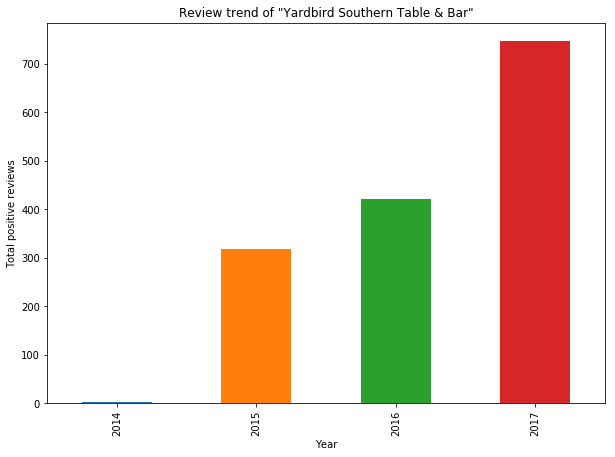

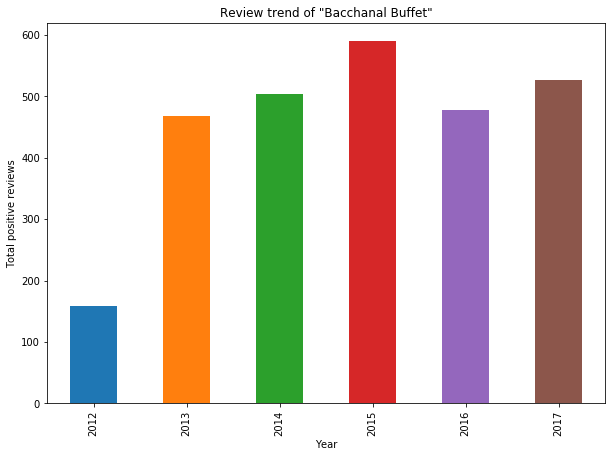

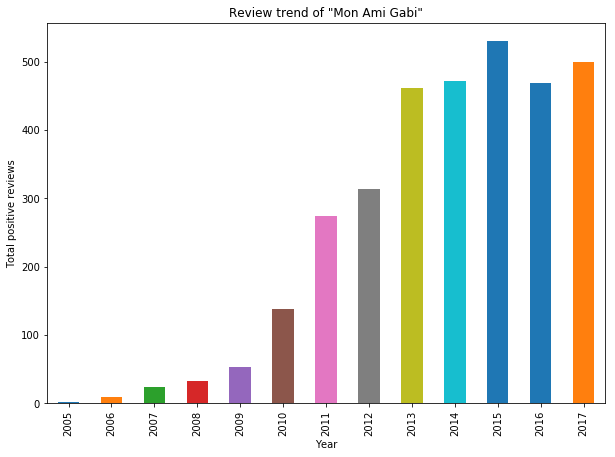

In [23]:
top_business = 3 #this parameter can be changed to see the trends of how many ever trending business as we want
temp = yelp_review[["business_id",'year',"stars"]]
five_star_reviews = temp[temp["stars"]>4]
trending_business_reviews = five_star_reviews.groupby(["business_id",'year']).size().reset_index(name='counts')

trending = trending_business_reviews.sort_values(['year','counts'])[::-1][:top_business].business_id.values
for  business_id in trending:
    record = trending_business_reviews.loc[trending_business_reviews['business_id'] == business_id]
    business_name = yelp_business.loc[yelp_business['business_id'] == business_id].name.values[0]
    series = pd.Series(record["counts"].values, index=record.year.values, name='Trending business')
    axes = series.plot(kind="bar",figsize=(10, 7))
    plt.xlabel('Year', axes=axes)
    plt.ylabel('Total positive reviews', axes=axes)
    plt.title('Review trend of {}'.format(business_name), axes=axes)
    plt.show()
    #len(trending_business_reviews)

From above graphs one can easliy see that "Yardbird southern table & bar" is new commer in business and has got most reviews in year 2017. And "Mon Ami Gabi" is able to maintain it reviews which indicate persistant quality standards.

Anyone can explore more insights by changing value of `top_business`.

# Categories of top reviewed businesses

This section can answer the question "What categories of businesses are at succeeding?" Good reviews means customers are happy to visit and take time to write reviews.

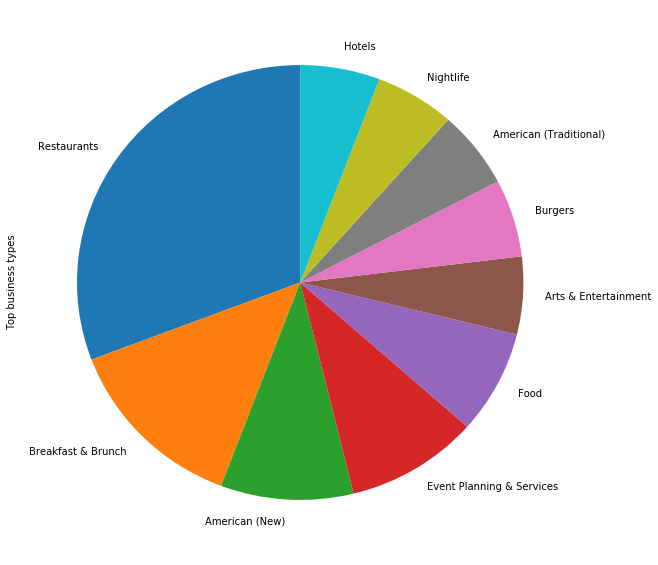

In [24]:
num_cat =10 # to show top 10 catrgories
top_business = 30 # choose categories of top 30 businesses
cat_data = top_business_data.sort_values("rated")[::-1][:top_business]
#cat_data.categories
Categories={}
for cat in cat_data.categories.values:
    all_categories= cat.split(";")
    for x in all_categories:
        try :
            Categories[x] =Categories[x]+1
        except:
            Categories[x]=1
top_categories = pd.DataFrame.from_dict(data= Categories,orient="index")
top_categories.reset_index(inplace=True)
top_categories.columns = ['category', 'occurance']

x_val=top_categories.sort_values("occurance")[::-1][:num_cat].occurance.values
labels=top_categories.sort_values("occurance")[::-1][:num_cat].category.values
series = pd.Series(x_val, index=labels, name='Top business types')
series.plot.pie(figsize=(10, 10),startangle=90)



Anyone interested in getting more categories can change  value of `num_cat` and `top_business`.

# Categories of trending businesses

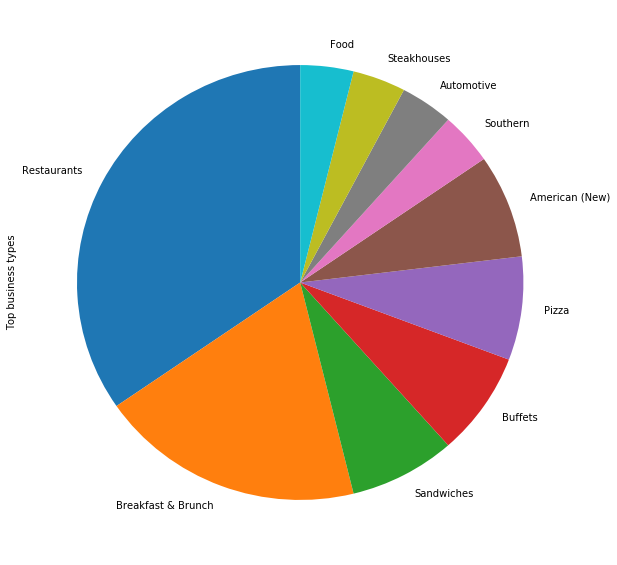

In [25]:
num_cat =10 # to show top 10 catrgories
top_business = 40 # choose categories of top 30 businesses
business_ids = trending_business_reviews.sort_values(['year','counts'])[::-1][:top_business].business_id.values
cat_data = top_business_data.loc[top_business_data['business_id'].isin(business_ids)]
#cat_data.categories
Categories={}
for cat in cat_data.categories.values:
    all_categories= cat.split(";")
    for x in all_categories:
        try :
            Categories[x] =Categories[x]+1
        except:
            Categories[x]=1
top_categories = pd.DataFrame.from_dict(data= Categories,orient="index")
top_categories.reset_index(inplace=True)
top_categories.columns = ['category', 'occurance']

x_val=top_categories.sort_values("occurance")[::-1][:num_cat].occurance.values
labels=top_categories.sort_values("occurance")[::-1][:num_cat].category.values
series = pd.Series(x_val, index=labels, name='Top business types')
series.plot.pie(figsize=(10, 10),startangle=90)


By comparing above two pie chart one can say "Art and Entertaintment" is not a trending category of business to invest on. "Sandwitches" and "Mexican" are becoming more trending categories.

Anyone interested in getting more insights can change  value of `num_cat` and `top_business` in above code.

# Negatively reviewed businesses

In [29]:
# here we calculate all the business which are not doing well according to yelp reviews
bottom_reviewed = yelp_review[yelp_review["stars"]<2]
bottom_reviews_dict ={} 

for business_id in bottom_reviewed["business_id"].values:
    try :
        bottom_reviews_dict[business_id] =bottom_reviews_dict[business_id]+1
    except:
        bottom_reviews_dict[business_id]=1
        
bottombusiness = pd.DataFrame.from_dict(data= bottom_reviews_dict,orient="index")

bottombusiness.reset_index(inplace=True)
#bottombusiness.head()
bottombusiness.columns = ['business_id', 'rated']

Plotting the businesses with maximum number of Negative(>2 stars) reveiws.

Text(0,0.5,'Total 1 star ratings')

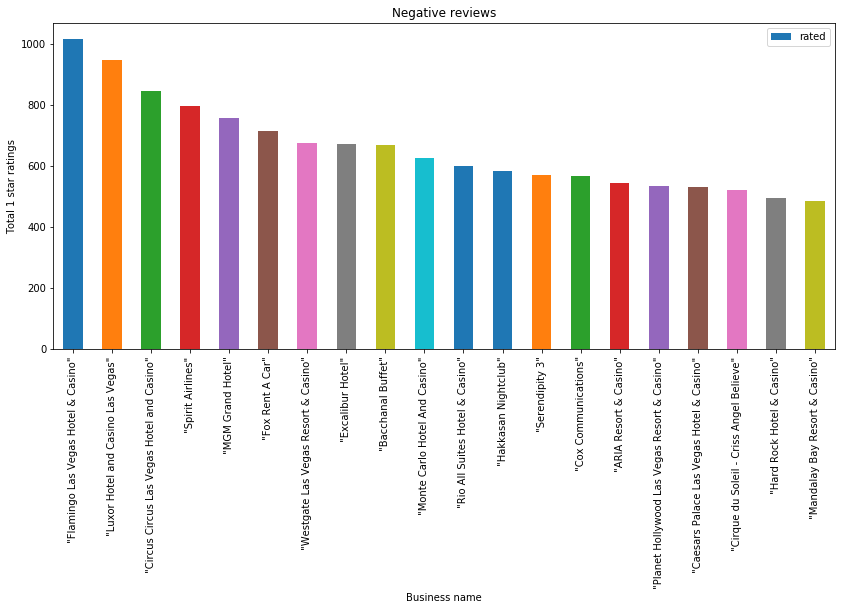

In [30]:
#plotting businesses with negative reviews
top_count= 20 # 20 business with the most negative reviews
right=pd.DataFrame(yelp_business[['business_id',"name","categories"]].values,
                    columns=['business_id',"Business name","categories"])

bottom_business_data = pd.merge(bottombusiness,right=right, how="inner",on='business_id')
bottom_business_data.sort_values("rated")[::-1][:top_count].plot(x="Business name",y="rated", 
                                                   kind="bar",figsize=(14,6),
                                                   title='Negative reviews').set_ylabel("Total 1 star ratings")



Above plot shows that most of the "Casino" are negatively reviewed.

Anyone interested in getting more categories can change  value of `top_count`.

# Business categories which needs improvement

The categories of businesses which which are getting negative reviews definitely need to improve their services. Or this insight can be used by their competitors to start new business nearby.

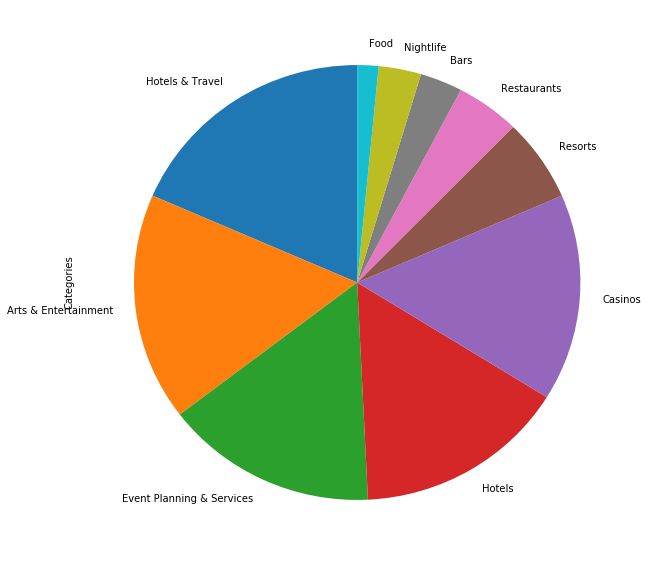

In [31]:
# This plot shows us the business sectors or categories which are doing badly currently according to their yelp reviews
num_cat =10 # to show top 10 catrgories
bottom_business = 30 # choose categories of top 30 businesses
cat_data = bottom_business_data.sort_values("rated")[::-1][:bottom_business]

Categories={}
for cat in cat_data.categories.values:
    all_categories= cat.split(";")
    for x in all_categories:
        try :
            Categories[x] =Categories[x]+1
        except:
            Categories[x]=1
bottom_categories = pd.DataFrame.from_dict(data= Categories,orient="index")
bottom_categories.reset_index(inplace=True)
bottom_categories.columns = ['category', 'occurance']

x_val=bottom_categories.sort_values("occurance")[::-1][:num_cat].occurance.values
labels=bottom_categories.sort_values("occurance")[::-1][:num_cat].category.values
series = pd.Series(x_val, index=labels, name='Categories')
series.plot.pie(figsize=(10, 10),startangle=90)




Anyone interested in getting more categories can change  value of `num_cat` and `bottom_business`.

# Lets find most frequent words in Negative reviews


Basically, we will find most frequent words in reviews to get an overview of why users gave low ratings. These words could be related to those business attributes or services about which users are most unhappy.

In [32]:
# these are helper functions 
# directly copied from https://gist.github.com/benhoyt/dfafeab26d7c02a52ed17b6229f0cb52

def tokenize(s):
    """Convert string to lowercase and split into words (ignoring
    punctuation), returning list of words.
    """
    word_list = re.findall(r'\w+', s.lower())
    filtered_words = [word for word in word_list if word not in stopwords.words('english')]
    return filtered_words


def count_ngrams(lines, min_length=2, max_length=4):
    """Iterate through given lines iterator (file object or list of
    lines) and return n-gram frequencies. The return value is a dict
    mapping the length of the n-gram to a collections.Counter
    object of n-gram tuple and number of times that n-gram occurred.
    Returned dict includes n-grams of length min_length to max_length.
    """
    lengths = range(min_length, max_length + 1)
    ngrams = {length: collections.Counter() for length in lengths}
    queue = collections.deque(maxlen=max_length)

    # Helper function to add n-grams at start of current queue to dict
    def add_queue():
        current = tuple(queue)
        for length in lengths:
            if len(current) >= length:
                ngrams[length][current[:length]] += 1

    # Loop through all lines and words and add n-grams to dict
    for line in lines:
        for word in tokenize(line):
            queue.append(word)
            if len(queue) >= max_length:
                add_queue()

    # Make sure we get the n-grams at the tail end of the queue
    while len(queue) > min_length:
        queue.popleft()
        add_queue()

    return ngrams

def print_most_frequent(ngrams, num=10):
    """Print num most common n-grams of each length in n-grams dict."""
    for n in sorted(ngrams):
        print('----- {} most common {}-word phrase -----'.format(num, n))
        for gram, count in ngrams[n].most_common(num):
            print('{0}: {1}'.format(' '.join(gram), count))
        print('')

def print_word_cloud(ngrams, num=5):
    """Print word cloud image plot """
    words = []
    for n in sorted(ngrams):
        for gram, count in ngrams[n].most_common(num):
            s = ' '.join(gram)
            words.append(s)
            
    cloud = WordCloud(width=1440, height= 1080,max_words= 200).generate(' '.join(words))
    plt.figure(figsize=(20, 15))
    plt.imshow(cloud)
    plt.axis('off');
    plt.show()
    print('')
    
            

Analysing business:  "Flamingo Las Vegas Hotel & Casino"
----- 10 most common 2-word phrase -----
front desk: 637
go room: 394
las vegas: 377
customer service: 322
resort fee: 231
go rooms: 204
stayed flamingo: 179
middle strip: 173
stay flamingo: 172
room service: 163

----- 10 most common 3-word phrase -----
called front desk: 105
non smoking room: 72
right middle strip: 60
flat screen tv: 43
room strip view: 41
flamingo las vegas: 36
go deluxe room: 35
spend much time: 35
call front desk: 34
called guest services: 31



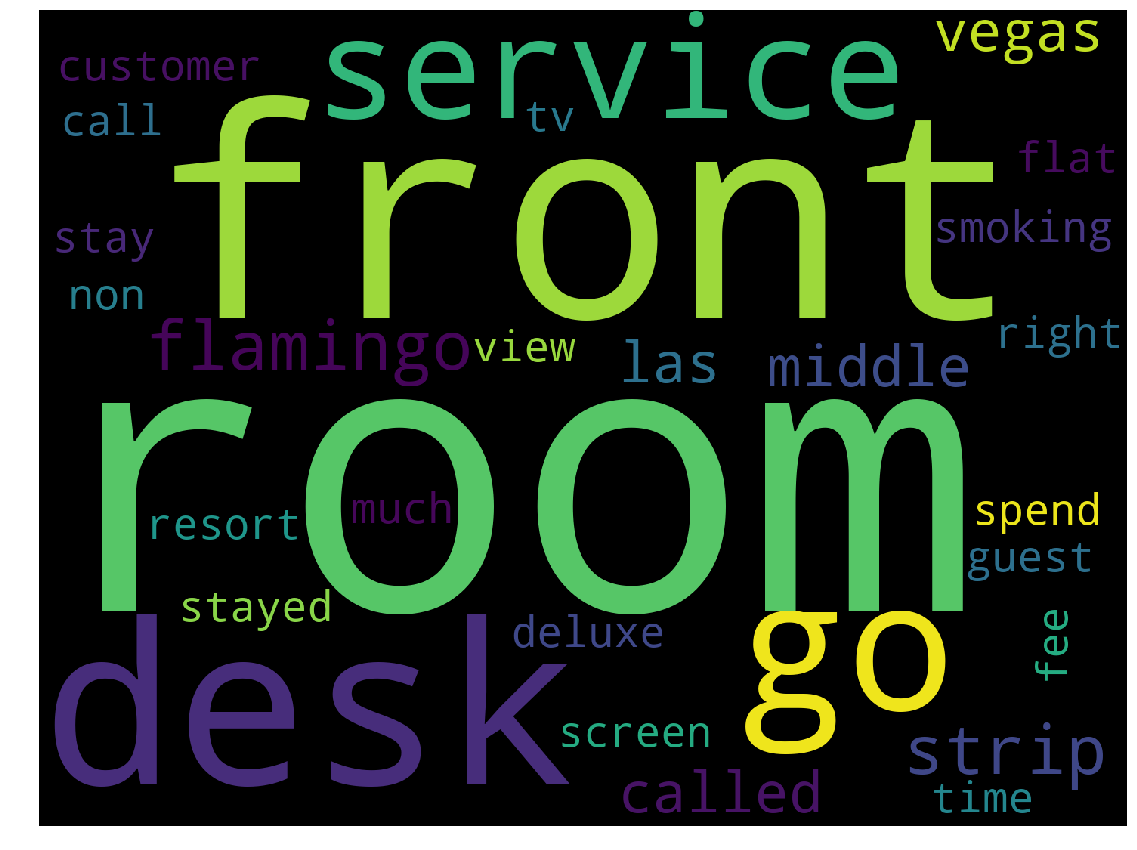

In [33]:
num_business_analysis = 1 # basically this will tell how much computing and diverse our analysis will be
business_ids=bottom_business_data.sort_values("rated")[::-1][:num_business_analysis].business_id.values
business_names = bottom_business_data.sort_values("rated")[::-1][:num_business_analysis]["Business name"].values
# get all the reviews and analyse them
#business_names
for i, business_id in enumerate(business_ids):
    # now extract reviews from reviews data
    print("Analysing business: ",business_names[i])
    reviews = yelp_review.loc[yelp_review['business_id'] == business_id].text.values
    most_used_text = count_ngrams(reviews,max_length=3)
    print_most_frequent(most_used_text, num=10)
    print_word_cloud(most_used_text, 10)
    #print ("total reviews ",len(reviews))
    

From above image one can easily understand there are some problems related to front desk, room service, customer service tv screen. This plot doesnt make a lot of sense but still, it gives an overview of most used words in reviews about which users are unhappy.

From business point of view this insight is very useful and business owners can easily use this information to improve their services.

Anyone interested in more insights can change `num_business_analysis`.

# Most frequent tips


Using both reviews and tips data, business can work on improving the specific areas of their business. Lets see if tips are really useful for insights.

Analysing business:  "Flamingo Las Vegas Hotel & Casino"
----- 10 most common 2-word phrase -----
go room: 11
total rewards: 11
go rooms: 8
customer service: 8
great location: 7
parking lot: 6
check line: 5
nathan burton: 5
pool party: 5
early check: 5

----- 10 most common 3-word phrase -----
total rewards card: 4
great customer service: 3
boyz ii men: 2
watch nathan burton: 2
food court closed: 2
nathan burton comedy: 2
strip view room: 2
use promo code: 2
self check kiosks: 2
10am poker tournament: 2

----- 10 most common 4-word phrase -----
back work sleep necessary: 2
work sleep necessary yet: 2
get total rewards card: 2
hotel casino okay based: 1
casino okay based late: 1
okay based late gangster: 1
based late gangster era: 1
late gangster era bugsy: 1
gangster era bugsy siegal: 1
era bugsy siegal photos: 1



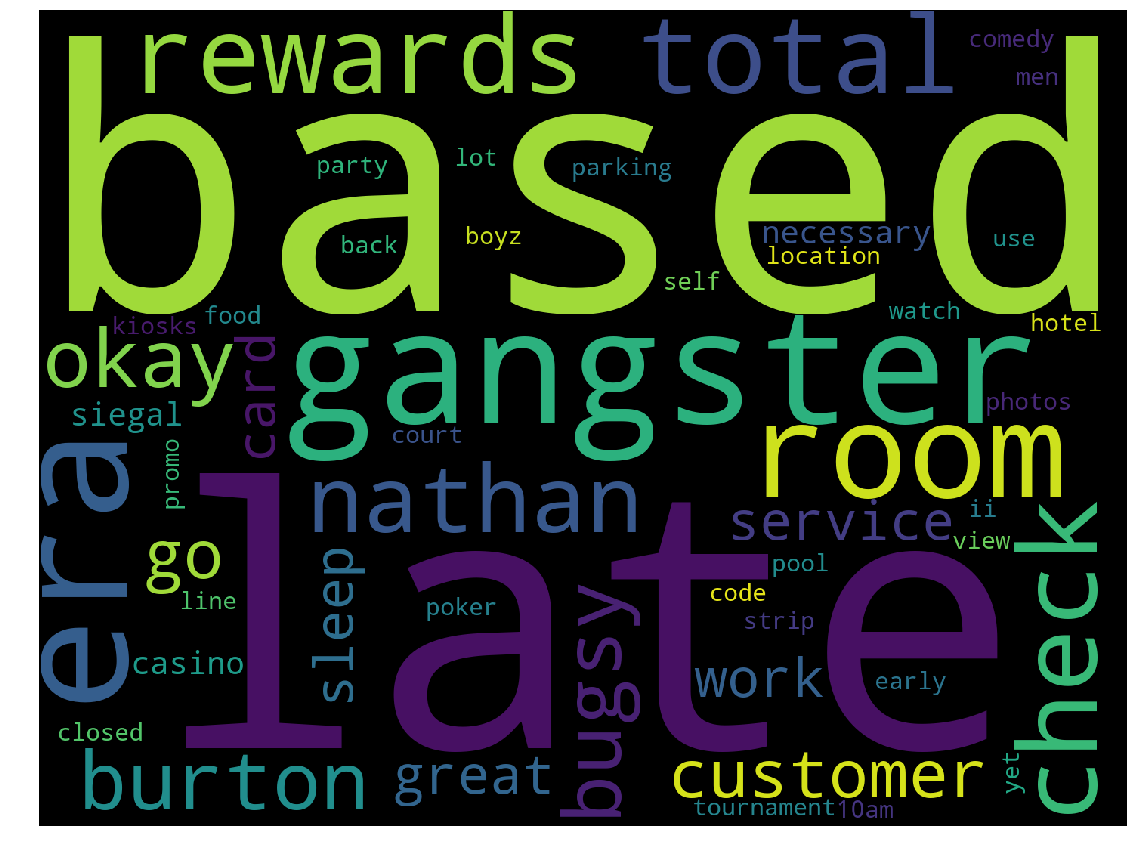


Analysing business:  "Luxor Hotel and Casino Las Vegas"
----- 10 most common 2-word phrase -----
paying bills: 20
work ten: 20
busy night: 18
grave shift: 16
good nite: 12
long 10: 11
steve work: 11
busy nite: 10
ten busy: 9
good mourning: 9

----- 10 most common 3-word phrase -----
grave shift rocks: 7
steve aka neck: 6
work ten busy: 6
half way threw: 6
way threw shift: 6
happy new year: 5
work long 10: 4
paying bills work: 4
work paying bills: 4
work busy night: 4

----- 10 most common 4-word phrase -----
half way threw shift: 6
grave shift rocks steve: 4
holler ur boy steve: 3
work busy night luxor: 2
friends steve aka neck: 2
aka neck paying bills: 2
happy new year friends: 2
going ten paying bills: 2
ten paying bills everybody: 2
paying bills everybody great: 2



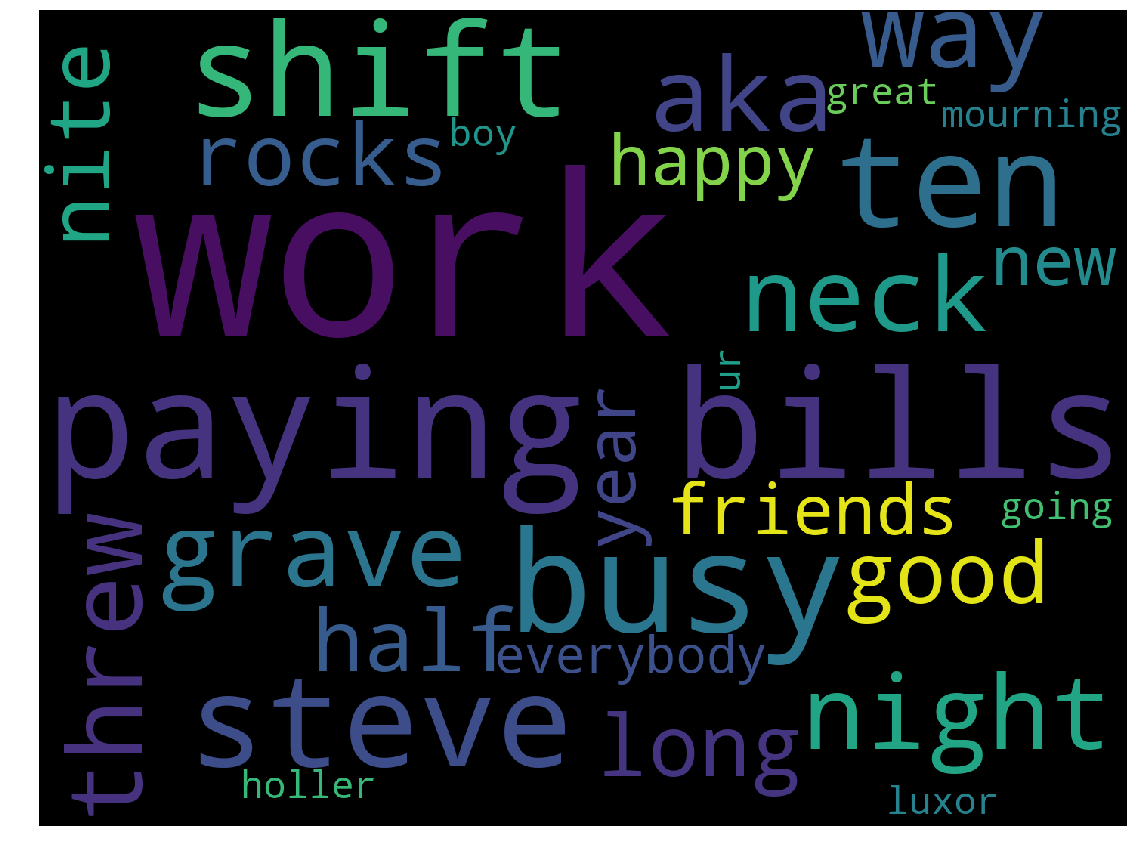

In [34]:
num_business_analysis = 2 # basically this will tell how much computing and diverse our analysis will be
business_ids=bottom_business_data.sort_values("rated")[::-1][:num_business_analysis].business_id.values
business_names = bottom_business_data.sort_values("rated")[::-1][:num_business_analysis]["Business name"].values
# get all the reviews and analyse them
#business_names
for i, business_id in enumerate(business_ids):
    # now extract reviews from reviews data
    print("Analysing business: ",business_names[i])
    reviews = yelp_tips.loc[yelp_tips['business_id'] == business_id].text.values
    most_used_text = count_ngrams(reviews,max_length=4)
    print_most_frequent(most_used_text, num=10)
    print_word_cloud(most_used_text, 10)
    #print ("total reviews ",len(reviews))

Tips seem very random and unuseful for business as these contains basic greetings and more general phrases like "paying bills" "busy night".

# Lets find relationship between users's friends and review patterns

In [35]:
top_users = 15 # we are considering 15 users who have written most reviews
user_most_reviews = yelp_review.groupby(['user_id']).size().reset_index(name='counts')
top_users_ids = user_most_reviews.sort_values(['counts'])[::-1][:top_users].user_id.values

after taking top Users with most reviews , we find out the number of friends these Top users have and take out their User_ID.

In [36]:
# this function helps us find friends of the top users
user_frnds = {}
for  users_id in top_users_ids:
    
    record = yelp_users.loc[yelp_users['user_id'] == users_id]
    user_frnds[users_id] = {}
    user_frnds[users_id]["name"]= record.name.values[0]
    user_frnds[users_id]["friends"]= record.friends.values[0]
    if record.friends is not "None":
        user_frnds[users_id]["friends_count"]= len(record.friends.values[0].split(","))
    else:
        user_frnds[users_id]["friends_count"]=0
    user_frnds[users_id]["review_count"]=record.review_count.values[0]
    user_frnds[users_id]["fans"]=record.fans.values[0]

creating a df with Friends and Fans data.

In [41]:
 user_friend_df = pd.DataFrame.from_dict(data= user_frnds,orient="index")

Plotting no. of reviews per User, with no. of friends and fans.

In [42]:
#this dataframe shows us the top users and their friends on yelp
user_friend_df.head()

,name,friends,friends_count,review_count,fans
62GNFh5FySkA3MbrQmnqvg,Chad,"SK1BhhBny8JNEZnsrq-qDA, SOCNCNisrOk-queHDhtpLA...",403,2215,136
CxDOIDnH8gp9KXzpBHJYXw,Jennifer,"_5HFgadpCIaSVINVvse2Kw, v4dBtkYuBNM9Oo2DwAQXNg...",517,5868,610
DK57YibC5ShBmqQl97CKog,Karen,"b5-bCtvbvj65vT10UBz_PQ, fsRF1PCJ16mn3T0eXg-IOg...",930,2063,255
ELcQDlf69kb-ihJfxZyL0A,Brad,"6HdvRKRt2bo5MYIOHJOZOg, lTt0mEhuUsHh-IYywQH1-A...",250,1509,53
PKEzKWv_FktMm2mGPjwd0Q,Norm,"uIjj7EIVBU4kGNgmKPO02A, pbBn0hXz8diwlZ3RIy4UUg...",1120,2239,224


C:\Users\Jayanth Chava\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


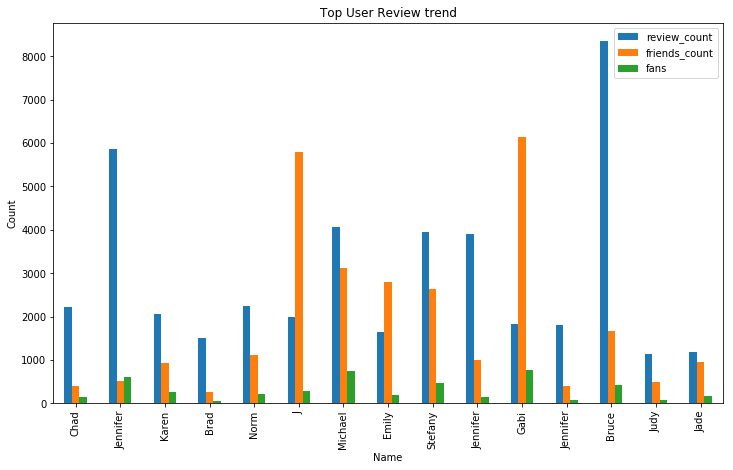

In [43]:
# plotting the top users and their freinds and fans count
axes = user_friend_df.plot(x="name", y=["review_count", "friends_count", "fans"],
                           kind="bar",figsize=(12, 7))
plt.xlabel('Name', axes=axes)
plt.ylabel('Count', axes=axes)
plt.title('Top User Review trend'.format(business_name), axes=axes)
plt.show()

From above graph we can see there is no defined relashionship between user's fans, friends and review count. User reviewing for a business totally depends on user's character and/or satisfaction with business services.

# Does user's friends infulence business review?

Lets find trending business and its top users. Then we will cross check with yelp user database if a particular user's friend also has given rating to that business or not.

In [44]:
business_rank = 4 # 0 to 9
temp = yelp_review[["business_id",'year',"stars"]]
five_star_reviews = temp[temp["stars"]>4]
trending_business_reviews = five_star_reviews.groupby(["business_id",'year']).size().reset_index(name='counts')

business_id = trending_business_reviews.sort_values(['year','counts'])[::-1][:10].business_id.values[business_rank]
business_name = yelp_business.loc[yelp_business['business_id'] == business_id].name.values[0]

In [45]:
user_reviws = yelp_review.loc[yelp_review['business_id']==business_id]
topuser_reviws = user_reviws.groupby(['user_id']).size().reset_index(name='counts')
print("Total users who gave ratings to {} are {}".format(business_name,len(topuser_reviws)))

Total users who gave ratings to "Mr Mamas" are 1608


In [46]:
top_users = 50 #len(topuser_reviws)// 10
topuser_reviws = topuser_reviws.sort_values(['counts'])[::-1][:top_users]
print(topuser_reviws)

                     user_id  counts
1607  zzHSF3oCjXqgsYuVJPgdvw       1
539   KHt4wF6kXQZTAZ485SIv6g       1
529   JqjAthJThuVYgTh4iWDZ2A       1
530   JujdEiaUhw2raemUnJEhxw       1
531   K-WT1HerFUDcK-4wXYLkOg       1
532   K03cHzh69SsvXqsdMvQlNw       1
533   K2wXDFXJWazQrhh6ZSLyhg       1
534   K5ehuj3-AU-5LA9zU5I6fg       1
535   K8-mRXFRLF-eisFo5kr1xQ       1
536   KA0gsDlw778yAXnIs5APWQ       1
537   KCuRMC_PbMe36tI7tNd5pQ       1
538   KDNXgwGM_qEyIj-5NQr-mw       1
540   KJ2HGUErJvpRi7CZJj0KzQ       1
502   Inlws-5YGYxo7rUNL07w7g       1
541   KJqbRtsgsOReJDY421ptVw       1
542   KMmT7GlGPvzKwEufHA7nVA       1
543   KSaur56waK0T5SEKcy5AIw       1
544   KUcXU40pk1TftQ4J5hOnZw       1
545   KWFiZKiZBANVxuhm4MLBNw       1
546   KXJfqISSxyYgpOdD3Ecq2Q       1
547   KYGqNb0JSKkQSJfaWiyJCg       1
548   KZvcXtsdMbaQQ2DNGFwCjw       1
549   K_B2Q7eM0TUny4tdL9CMrA       1
550   Kc6XUaNsMqGKr6QWoMD8oA       1
528   JqftvD0JBPXakBtoAhCgaA       1
527   JqP9_2Ky-X1MRro0pBPPNQ       1
5

In [47]:
%%time

users_ids = topuser_reviws.user_id.values
users_ids = pd.merge(topuser_reviws,right=yelp_users, how="inner",on='user_id')# merging two datasets
users_ids =users_ids [["name","user_id", "friends"]]


Wall time: 1.95 s


We find the data of top users and no. of reviews by friends of those users for a particular business. 

In [48]:
%%time
# creating a function to calculate the influence of users on their friends
def calc_frnd_review(frnds, business_id, yelp_review):
        frnds = frnds.split(',')
        #count reviews
        #frnds = yelp_users.loc[(yelp_users['user_id'].isin(frnds)) & (yelp_users["review_count"]>0 )].user_id.values
        friend_review = yelp_review.loc[(yelp_review['business_id']==business_id) &
                                        (yelp_review['user_id'].isin(frnds))
                                       ][["stars","user_id"]]
        friend_review_cnt = len(friend_review.user_id.values)
        if(friend_review_cnt>0):
            total_stars = friend_review.stars.sum()
        else:
            total_stars = 0
        return  friend_review_cnt,total_stars

users_ids[["frnd_count","total_stars"]]= users_ids["friends"].apply(lambda frnds: pd.Series(calc_frnd_review(frnds, business_id, yelp_review), index=['frnd_count','total_stars']))

Wall time: 27.8 s


In [49]:
users_ids[users_ids["frnd_count"]>0]

,name,user_id,friends,frnd_count,total_stars
37,Nelson,JMMb379O40Q8-BomOeZMSw,"9Lu3J0Ljvr8vyj2SFU4MNg, nYCNgihdp8fIsQGr0XKoTA...",1,5


So we can see here, not much users could have been somehow influenced by their friends's top ratings to a business, because there is only one user whose friend also rated 5 star for "Mr Mamas" when "Nelson" gave 5 rating to it (Here we have taken only 50 users out of 1608 users into account because this task is very resource heavy).

We take the Review data and change the text to lower case and  remove white spacaes.

And then we devide the text  to train(70%) and test data(30%). 

In [50]:
%%time
#As Scikit cannot work with the words, we need to assign a new dimension to each word and work with the word counts

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
import nltk

cleanupdata = re.compile('[^a-z]+')
def cleanup(sentence):
    sentence = sentence.lower()
    sentence = cleanupdata.sub(' ', sentence).strip()
    #sentence = " ".join(nltk.word_tokenize(sentence))
    return sentence

yelp_review["Summary_Clean"] = yelp_review["text"].apply(cleanup) 

train, test = train_test_split(yelp_review, test_size=0.3)
print("%d --> Training data, %d --> Test data" % (len(train), len(test)))

3683167 --> Training data, 1578501 --> Test data
Wall time: 3min 50s


We take texts reviews of only 1,2 star reviews(Negitive) and 4,5 star reviews(Positive). We do not consider 3 satr reviews as we consider them neutral reviews.

In [51]:
df = yelp_review[yelp_review['stars'] != 3]

we define X as review text which we have already cleaned up.
and Y is the 0 or 1 value coresponding to the stars of the review
here we considered 1,2=0 and 4,5=1.

In [52]:
%%time
X = df['text']
y_dict = {1:0, 2:0, 4:1, 5:1}
y = df['stars'].map(y_dict)

Wall time: 1.48 s


we perform the Logistic regression with X and Y. We calculate the Coefficient topd Negitive words from the reviews positive an

# Applying Logistic Regression

The code in the document by Eugen Anghel is referred from: https://www.kaggle.com/eugen1701/predicting-sentiment-and-helpfulness

In [53]:
%%time
#WARNING this logistic regression model takes around 1hr to run.
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

c = CountVectorizer(stop_words = 'english')

def text_fit(X, y, model,clf_model,coef_show=1):
    
    X_c = model.fit_transform(X)
    print('# Features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('Number of train records: {}'.format(X_train.shape[0]))
    print('Number of test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))
    
    if coef_show == 1: 
        w = model.get_feature_names()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('--- Top 20 positive words ---')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('--- Top 20 negative words ---')        
        print(coeff_df.tail(20).to_string(index=False))
    
    
text_fit(X, y, c, LogisticRegression())

# Features: 680271
Number of train records: 3484640
Number of test records: 1161547
Model Accuracy: 0.953082397871115

--- Top 20 positive words ---
Coefficient                   Word
   2.904480                 peeler
   2.866278              smoothest
   2.850079                 haters
   2.797833                godsend
   2.695339                  prydz
   2.636598                    ari
   2.603862                   xlnt
   2.525659               daunting
   2.479200                onerous
   2.472703                   riki
   2.469914              huaraches
   2.462108               danielli
   2.460249               exceeded
   2.460063                 mazing
   2.459074          fluffanutters
   2.458797                    pvr
   2.458561               cazulada
   2.458000             pleasantly
   2.457740             enveloping
   2.437455  anythinguwantdelivery

--- Top 20 negative words ---
Coefficient              Word
  -2.539908            rudest
  -2.541666          boza

In [54]:
%%time
#Logistic Regression model on TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression


tfidf = TfidfVectorizer(stop_words = 'english')
text_fit(X, y, tfidf, LogisticRegression())

# Features: 680271
Number of train records: 3484640
Number of test records: 1161547
Model Accuracy: 0.9547715245272038

--- Top 20 positive words ---
Coefficient         Word
  18.761087    delicious
  17.857981      amazing
  16.348121        great
  15.393954    excellent
  14.713220      awesome
  13.736460      perfect
  13.158560    fantastic
  12.292101   pleasantly
  11.916355         best
  11.411444    perfectly
  11.363548   perfection
  11.302506         love
  10.952054       highly
  10.328097   incredible
  10.218557    wonderful
  10.139252        loved
   9.914342   phenomenal
   9.728683  outstanding
   9.543578        yummy
   9.494709        notch

--- Top 20 negative words ---
Coefficient            Word
  -9.670564           worse
  -9.815031      disgusting
  -9.876888       poisoning
  -9.980156    underwhelmed
 -10.236286            poor
 -10.566193  disappointment
 -10.587790        downhill
 -10.644257    unacceptable
 -10.725963      flavorless
 -10.758410   

In [55]:
yelp_review.head(1)

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,year,Sentiment,Summary_Clean
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0,2016,positive,super simple place but amazing nonetheless it ...


# Auto-Summazrization

Here we are going to run the package called sumy (taken from https://github.com/miso-belica/sumy), this package helps us summarize many number of lines into the number of sentences we want. The use of this function in our project is that we can get a few lines summarized review of every bussiness based on all its previously given yelp reviews.


We create a new column  of text length which will be useful during summarization

In [56]:
yelp_review['text_length'] = yelp_review['Summary_Clean'].apply(len)
yelp_review.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,year,Sentiment,Summary_Clean,text_length
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0,2016,positive,super simple place but amazing nonetheless it ...,204
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0,2016,positive,small unassuming place that changes their menu...,485
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0,2016,positive,lester s is located in a beautiful neighborhoo...,359
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0,2016,positive,love coming here yes the place always needs th...,504
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0,2016,positive,had their chocolate almond croissant and it wa...,225


lets just take a quick look at the updated line.

In [57]:
len(yelp_review.Summary_Clean)

5261668

As the sumy package can only summarize text files,  we are opening a new text file and retrieving the reviews of a given business and storing it in that file. So that we can read the file directly using its path and run the sumy algorithm on it.

In [58]:
f= open('datafile4.txt', 'w+')

for index in range(100):
    f.write(str(yelp_review.text[index]) )
f.close()

Down below we are running the sumy algorithm, we first use a plain text parser on the content of the text file it converts the words into lower case and removes punctuation and stopwords. the LexRankSummarizer ranks the reviews based on the number of stars and give us a summarized review.

In [59]:
%%time
#Import library essentials
from sumy.parsers.plaintext import PlaintextParser #We're choosing a plaintext parser here, other parsers available for HTML etc.
from sumy.nlp.tokenizers import Tokenizer 
from sumy.summarizers.lex_rank import LexRankSummarizer #We're choosing Lexrank, other algorithms are also built in

file = "C:/datafile4.txt" #name of the plain-text file
parser = PlaintextParser.from_file(file, Tokenizer("english"))
summarizer = LexRankSummarizer()

summary = summarizer(parser.document, 5) #Summarize the document with 5 sentences
print(summary)
#for sentence in summary:
    
    #print (sentence)

(<Sentence: We did have to wait for about 30 mins for a table for 4 (but it was later in the day).>, <Sentence: However, if you are here for lunch, it will take an hour and make sure you come a few minutes earlier otherwise it may be a long wait as it is small inside!they have some pretty interesting things here!>, <Sentence: I think this place is probably good for a drink (for the atmosphere and decor), but not so much for their food.Nice place by Cumberland place.>, <Sentence: BF had ordered a couple of beers, which he was not impressed at all with.Wanted to give this place a try since it was in my neighbourhood and I wouldn't have to go far.>, <Sentence: We had ordered:>)
Wall time: 9.63 s


Now, we are building a function for a summarized review where when we give the name of the business we get a summarized review of it in a desired number of sentences.

In [60]:
yelp_business.name = yelp_business.name.apply(lambda x: x.replace('"',''))

def summarized_review(Name):
    x = yelp_business['business_id'].where(yelp_business['name'] == Name)
    x = pd.DataFrame(x.dropna())
    i= x['business_id'].iloc[0]
    y = pd.DataFrame(yelp_review.text.loc[yelp_review['business_id'] == i])
    v = [y.index]
    t= open('datafile.txt', 'w+')

    for index in v:
            t.write(str(y.text[index]) )
            t.close()
     #Import library essentials
    from sumy.parsers.plaintext import PlaintextParser #We're choosing a plaintext parser here, other parsers available for HTML etc.
    from sumy.nlp.tokenizers import Tokenizer 
    from sumy.summarizers.lex_rank import LexRankSummarizer #We're choosing Lexrank, other algorithms are also built in

    file = "C:/Users/Jayanth Chava/Downloads/datafile.txt" #file path of your current directory
    parser = PlaintextParser.from_file(file, Tokenizer("english"))
    summarizer = LexRankSummarizer()

    summary = [summarizer(parser.document, 3)]#Summarize the document with 5 sentences
    #print(summary)
    for sentence in summary:
    
           print (sentence)       

In [61]:
%%time
summarized_review('Stephen Szabo Salon')


(<Sentence: 48950      I would  be grateful to those of you willing t... 493864     My family and I have been going to Stephens fo... 1706501    Amanda was an absolute peach!>, <Sentence: So sweet and tal... 2121654    I specifically requested Stephen as I thought ... 2551456    Paid $115.00 for about 8 highlights that dont ... 4125197    My daughter recently went to have her hair don... 4263675    I have been going to Stephen Szabo Salon for 1... 4355580    I went here to get my hair done for a wedding ... 4906394    I'm a regular here for many years.>, <Sentence: Totally rel... 5216722    I have been a client here for almost 12 years ... 5222873    Ok: I have been going to Stephen on\/off for 1... Name: text, dtype: object>)
Wall time: 1.6 s


Well the output isnt exactly to our liking , the function gives us the 5 top reviews. but the '...' doesnt let us read the whole review. We have made multiple attempts to better this out put, but we have failed. On troubleshooting we realised that maybe there is change in the data format when we are retrieving the reviews using the 'business name'. We changed the function and its code multiple times but could not rectify this error. 

# RECOMMENDATION SYSTEMS


A recommender system is a technology that is deployed in the environment where items (products, movies, events, articles) are to be recommended to users (customers, visitors, app users, readers) or the opposite. Typically, there are many items and many users present in the environment making the problem hard and expensive to solve

The explosive growth in the amount of available digital information and the number of visitors to the Internet have created a potential challenge of information overload which hinders timely access to items of interest on the Internet. Information retrieval systems, such as Google, DevilFinder and Altavista have partially solved this problem but prioritization and personalization (where a system maps available content to user’s interests and preferences) of information were absent. This has increased the demand for recommender systems more than ever before. Recommender systems are information filtering systems that deal with the problem of information overload by filtering vital information fragment out of large amount of dynamically generated information according to user’s preferences, interest, or observed behavior about item. Recommender system has the ability to predict whether a particular user would prefer an item or not based on the user’s profile.

Recommender systems are beneficial to both service providers and users. They reduce transaction costs of finding and selecting items in an online shopping environment. Recommendation systems have also proved to improve decision making process and quality . In e-commerce setting, recommender systems enhance revenues, for the fact that they are effective means of selling more products. In scientific libraries, recommender systems support users by allowing them to move beyond catalog searches. Therefore, the need to use efficient and accurate recommendation techniques within a system that will provide relevant and dependable recommendations for users cannot be over-emphasized.


Before we start developing our Recommendation Engine we are making a few considerations and working around a few constraints.
The size of the dataset makes it impossible to build a recommendation system on all the businesses and categories. The average laptop lacks the computational power to build such big matrices. Hence we decided to only run it on all the restaurants in the dataset.  

### Keeping only "restaurant" business data and other associated data on users and reviews
We reduced the business dataset to businesses that had “Restaurant” or “Food” in the category (restaurants). We then removed observations that had other “non-restaurant” categories, such as “Grocery”, “Auto Glass Services”, “Business Consulting”, etc. After reducing the business dataset, we reduced our review dataset in two ways:
* Only including reviews for businesses that existed in the reduced business (restaurant) dataset 
* Only including reviews for users that have at least 2 reviews (A single rating does not help determine similarities between restaurants)

In summary, we began with 156,639 observations. 15,502 of these observations contained "Food" or "Restaurants". After removing observations with irrelevant categories, we are left with 14,032 total observations.

In [62]:
def find_ftres_with_nan(df):
    all_nan = df.columns[df.isnull().all()].tolist()
    some_nan = df.columns[df.isnull().any()].tolist()
    print("All NaN Features: ", len(all_nan), all_nan, "Some NaN Features: ", len(some_nan), some_nan)
    return all_nan, some_nan

In [63]:
business = pd.read_csv('C:/YELP/business.csv')
all_nan, some_nan = find_ftres_with_nan(business)
business.head(1)

All NaN Features:  0 [] Some NaN Features:  9 ['address', 'attributes', 'categories', 'city', 'hours', 'latitude', 'longitude', 'neighborhood', 'postal_code']


,Unnamed: 0,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,0,1314 44 Avenue NE,"{'BikeParking': 'False', 'BusinessAcceptsCredi...",Apn5Q_b6Nz61Tq4XzPdf9A,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",Calgary,"{'Monday': '8:30-17:0', 'Tuesday': '11:0-21:0'...",1,51.091813,-114.031675,Minhas Micro Brewery,NaN,T2E 6L6,24,4.0,AB


Number of businesses that have both "food" and "restaurant" in their category:

In [64]:
# create a mask for restaurants
mask_restaurants = business['categories'].str.contains('Restaurants')

# create a mask for food
mask_food = business['categories'].str.contains('Food')

# apply both masks
restaurants_and_food = business[mask_restaurants & mask_food]

# number of businesses that have food and restaurant in their category
restaurants_and_food['categories'].count()

18010

Even after taking buisnesses that have both food and restaurant in their categories, there are still irrelevant business categories in the data. 

In [65]:
# an example row
restaurants_and_food.head(1)['categories'].values

array(['Tours, Breweries, Pizza, Restaurants, Food, Hotels & Travel'],
      dtype=object)

Thus, we manually identified additional categories that needed to be excluded specifically. 

In [66]:
categoryDF = restaurants_and_food['categories'].apply(lambda x: x[1:-1].split(',')).apply(pd.Series)
uniqueCategories = pd.DataFrame(categoryDF.stack().str.strip().unique())

In [67]:
categoriesToRemove = ['Grocery','Drugstores','Convenience Stores','Beauty & Spas','Photography Stores & Services',
                      'Cosmetics & Beauty Supply','Discount Store','Fashion','Department Stores','Gas Stations',
                      'Automotive','Music & Video','Event Planning & Services','Mobile Phones','Health & Medical',
                      'Weight Loss Centers','Home & Garden','Kitchen & Bath','Jewelry',"Children's Clothing",
                      'Accessories','Home Decor','Bus Tours','Auto Glass Services','Auto Detailing',
                      'Oil Change Stations', 'Auto Repair','Body Shops','Car Window Tinting','Car Wash',
                      'Gluten-Free','Fitness & Instruction','Nurseries & Gardening','Wedding Planning',
                      'Embroidery & Crochet','Dance Schools','Performing Arts',
                      'Wholesale Stores','Tobacco Shops','Nutritionists','Hobby Shops','Pet Services',
                      'Electronics','Plumbing','Gyms','Yoga','Walking Tours','Toy Stores','Pet Stores',
                      'Pet Groomers','Vape Shops','Head Shops',
                      'Souvenir Shops','Pharmacy','Appliances & Repair','Wholesalers','Party Equipment Rentals',
                      'Tattoo','Funeral Services & Cemeteries','Sporting Goods','Dog Walkers',
                      'Pet Boarding/Pet Sitting','Scavenger Hunts','Contractors','Trainers', 
                      'Customized Merchandise', 'Dry Cleaning & Laundry', 'Art Galleries'
                      'Tax Law', 'Bankruptcy Law', 'Tax Services', 'Estate Planning Law', 
                      'Business Consulting', 'Lawyers', 'Pet Adoption', 'Escape Games', 
                      'Animal Shelters', 'Commercial Real Estate', 'Real Estate Agents', 
                      'Real Estate Services', 'Home Inspectors']

Wall time: 0 ns


we then create a new dataframe with the remaining data.

In [69]:
restaurants_df = restaurants_and_food[~restaurants_and_food['categories'].str.contains('|'.join(categoriesToRemove))]

In [70]:
restaurants_df.to_csv('restaurants.csv')
restaurants_df = pd.read_csv('restaurants.csv', encoding='ISO-8859-1', index_col=0)
all_nan, some_nan = find_ftres_with_nan(restaurants_df)

All NaN Features:  0 [] Some NaN Features:  5 ['address', 'attributes', 'hours', 'neighborhood', 'postal_code']


### Expanding business attributes & categories
After cleaning the business dataset, we expanded the attributes into boolean features. The attributes were a collection of a string of a dictionary. We evaluated this string as a dictionary and applied pd.Series across the result, which expanded this dictionary into multiple Boolean columns, as well as a few more dictionary columns. All remaining dictionary columns were manipulated in the same manner, leaving us ~70 Boolean columns. The business dataset also had a variable, categories, that was a string of a list. We expanded this list into separate columns for each category. Lastly, we then reduced our user dataset by filtering to users that existed in the reduced review dataset. The following functions were used for this process. 

We now develop a function to create atrributes and expand attributes, this expands the attributes list given in the JSON file and creates a seperate column which contains information on all the attributes a certain business has. We use these attributes to categorize our restauraunts. 

In [68]:
#create_attributes

#takes a dataframe as an input, as well as a list of columns that are dictionaries
#takes each column that is a dictionary, and expands it into a series of dummy columns

def create_attributes(df, dictList):
    df.fillna(value='{}',inplace=True)
    for dictionaryColumn in dictList:
        
        #the attributes column is a string of dictionaries, so one extra step is taken to convert
        if dictionaryColumn == 'attributes':
            expandedColumns = df[dictionaryColumn].map(eval).apply(pd.Series)
        else:
            expandedColumns = df[dictionaryColumn].apply(pd.Series)
        
        df = pd.concat([df.drop(dictionaryColumn,axis=1), 
                   expandedColumns]
                  ,axis=1)
        
        
        
    return df

In [73]:

def expand_categories(df, cat_var, key):
    all_cats = df[cat_var].str.cat(sep=', ')
    all_cats = all_cats.replace('[', '')
    all_cats = all_cats.replace(']', '')
    all_cats = all_cats.replace("\'","")
    all_cats = all_cats.replace('"','')
    all_cats_list = all_cats.split(', ')
    unique_cats = list(set(all_cats_list))
    unique_cats.remove('Restaurants')
    unique_cats.remove('Food')
    df_cats = pd.DataFrame(index=df[key], columns=unique_cats, data=False)
    df_out = df.merge(df_cats, how='left', left_on=key, right_index=True)
    for cat in unique_cats:
        df_out[cat] = df_out[cat_var].str.contains(cat)
    return df_out  

lets take a look at our restaurants dataframe and the attributes column before expansion.

In [72]:
restaurants_df.head(1)

,Unnamed: 0.1,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,0,1314 44 Avenue NE,"{'BikeParking': 'False', 'BusinessAcceptsCredi...",Apn5Q_b6Nz61Tq4XzPdf9A,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",Calgary,"{'Monday': '8:30-17:0', 'Tuesday': '11:0-21:0'...",1,51.091813,-114.031675,Minhas Micro Brewery,NaN,T2E 6L6,24,4.0,AB


In [74]:
dictList = ['attributes', 'Ambience', 'BestNights', 'BusinessParking','Music','GoodForMeal'] 

In [78]:
%%time

dictList = ['attributes', 'Ambience', 'BestNights', 'BusinessParking','Music','GoodForMeal']
expanded = create_attributes(restaurants_df[['business_id','attributes']], dictList)
dropColumns = expanded.columns.get_loc(0)
keepColumns = list(compress(expanded.columns, ~dropColumns))
expanded = expanded[keepColumns]

C:\Users\Jayanth Chava\Anaconda3\lib\site-packages\pandas\core\frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Wall time: 18.7 s


now lets see the expanded columns

In [80]:
expanded.head()

,business_id,AgesAllowed,Alcohol,BYOB,BYOBCorkage,BikeParking,BusinessAcceptsBitcoin,BusinessAcceptsCreditCards,ByAppointmentOnly,Caters,...,RestaurantsCounterService,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,Smoking,WheelchairAccessible,WiFi
0,Apn5Q_b6Nz61Tq4XzPdf9A,NaN,NaN,NaN,NaN,False,NaN,True,NaN,NaN,...,NaN,False,True,2,True,NaN,True,NaN,NaN,NaN
19,vJIuDBdu01vCA8y1fwR1OQ,NaN,NaN,NaN,NaN,True,NaN,True,NaN,NaN,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,gJ5xSt6147gkcZ9Es0WxlA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,PMDlKLd0Mxj0ngCpuUmE5Q,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,...,NaN,False,True,2,False,NaN,True,NaN,NaN,NaN
32,kgffcoxT6BQp-gJ-UQ7Czw,NaN,none,NaN,NaN,True,NaN,True,NaN,True,...,NaN,False,True,1,False,False,True,NaN,NaN,no


merging dataframes

In [81]:
## Join expanded with restaurants_df
restaurants_df = restaurants_df.merge(expanded, how='left', left_on='business_id', right_on='business_id')
restaurants_df.drop('attributes', axis=1, inplace=True)

In [82]:
restaurants_df = expand_categories(restaurants_df, 'categories', 'business_id')
restaurants_df.drop('categories', axis=1, inplace=True)
# Variables that won't be used
# rest_vars_to_drop = ['address', 'hours', 'latitude', 'longitude', 'name']
rest_vars_to_drop = ['address', 'hours', 'latitude', 'longitude']
restaurants_final = restaurants_df.drop(rest_vars_to_drop, axis=1)


C:\Users\Jayanth Chava\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  from ipykernel import kernelapp as app


After cleaning up the business data, we kept relevant review and user data only. 

In [83]:
restaurants_final.to_csv('C:/Users/Jayanth Chava/Downloads/restaurants_final.csv')

Now we filter the data even more. 
- we drop columns where the ID's are null
- only select restaurants
- only consider user ID's with more than one review

In [84]:
def reduce_review(df, business_list):
    
    #drop columns where business_id or user_id is null
    df.dropna(subset=['business_id','user_id'], how='any',inplace=True)
    
    #restrict to businesses that are restaurants
    df = df[df['business_id'].isin(business_list)]
    
    #only keep user_id's with more than one review
    df = df[df.groupby('user_id').user_id.transform(len) > 1]
    
    #verify this worked by taking the minimum amount of user_id counts
    print('The minimum amount of reviews per user is {}'
          .format(np.min(df.groupby('user_id')['business_id'].count())))
    return df

Now we are personalizing the dataframe to our liking by expanding the date, and renaming columns for better utility puproses.

In [92]:
review = pd.read_csv('C:/YELP/review.csv',encoding = "ISO-8859-1",index_col=0)
review.head(1)

C:\Users\Jayanth Chava\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,iCQpiavjjPzJ5_3gPD5Ebg,0,2011-02-25,0.0,x7mDIiDB3jEiPGPHOmDzyw,2.0,The pizza was okay. Not the best I've had. I p...,0.0,msQe1u7Z_XuqjGoqhB0J5g


In [85]:

restaurant_reviews = reduce_review(review, restaurants_final['business_id']) #create dataframe
_, _ = find_ftres_with_nan(restaurant_reviews) #report if there are null values

restaurant_reviews['review_date'] = pd.to_datetime(restaurant_reviews['date'])
restaurant_reviews['review_year'] = restaurant_reviews['review_date'].dt.year
restaurant_reviews['review_month'] = restaurant_reviews['review_date'].dt.month
restaurant_reviews['review_weekday'] = restaurant_reviews['review_date'].dt.weekday_name

rename_cols = {'cool': 'review_cool','funny':'review_funny','stars':'review_stars','useful':'review_useful'}
restaurant_reviews.rename(columns=rename_cols, inplace=True)
review_cols_to_drop = ['text', 'review_date', 'date']
restaurant_reviews.drop(review_cols_to_drop, axis=1, inplace=True)

C:\Users\Jayanth Chava\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The minimum amount of reviews per user is 2
All NaN Features:  0 [] Some NaN Features:  0 []


In [86]:
restaurant_reviews.head(1)

,business_id,review_cool,review_funny,review_id,review_stars,review_useful,user_id,review_year,review_month,review_weekday
4,Ums3gaP2qM3W1XcA5r6SsQ,0,0.0,jsDu6QEJHbwP2Blom1PLCA,5.0,0.0,msQe1u7Z_XuqjGoqhB0J5g,2014,9,Friday


In [87]:
restaurant_reviews.to_csv('C:/Users/Jayanth Chava/Downloads/restaurant_reviews_final.csv')

Now, we modify the users dataframe collected from the CSV file and expand it and rename a few columns and save it into a new dataframe.

In [89]:
users_df = pd.read_csv('C:/YELP/user.csv',encoding = "ISO-8859-1",index_col=0)
users_df.head()

C:\Users\Jayanth Chava\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,...,cool,elite,fans,friends,funny,name,review_count,useful,user_id,yelping_since
0,2.00,0,0,0,0,0,0,0,0,0,...,0,None,0,None,0,Susan,1,0,lzlZwIpuSWXEnNS91wxjHw,2015-09-28
1,5.00,0,0,0,0,0,0,0,0,0,...,0,None,0,None,0,Daipayan,2,0,XvLBr-9smbI0m_a7dXtB7w,2015-09-05
2,4.00,0,0,0,0,0,0,0,0,0,...,0,None,0,None,0,Andy,1,0,QPT4Ud4H5sJVr68yXhoWFw,2016-07-21
3,4.05,0,0,0,0,0,0,0,0,0,...,0,None,0,None,0,Jonathan,19,0,i5YitlHZpf0B3R0s_8NVuw,2014-08-04
4,3.00,0,0,0,0,0,0,0,0,0,...,0,None,0,None,0,Shashank,3,0,s4FoIXE_LSGviTHBe8dmcg,2017-06-18


In [88]:
%%time
users_df = pd.read_csv('C:/YELP/user.csv',encoding = "ISO-8859-1",index_col=0)
users_w_reviews = users_df[users_df['user_id'].isin(restaurant_reviews['user_id'])].copy()

list_user_vars = ['average_stars', 'compliment_cool', 'compliment_cute', 'compliment_funny', 
                  'compliment_hot', 'compliment_list', 'compliment_more', 'compliment_note', 
                  'compliment_photos', 'compliment_plain', 'compliment_profile', 
                  'compliment_writer', 'cool', 'elite', 'fans', 'friends', 'funny', 
                  'name', 'review_count', 'useful'] #list we want to rename columns with

vars_to_rename_users = dict(zip(list_user_vars, ['user_' + var for var in list_user_vars]))
users_w_reviews = users_w_reviews.rename(columns=vars_to_rename_users) # renaming columns

users_w_reviews['yelping_since'] = pd.to_datetime(users_w_reviews['yelping_since']) #records from when the user has been writing reviews
users_w_reviews['yelping_since'] = users_w_reviews['yelping_since'].dt.year

users_w_reviews['user_elite_flag'] = users_w_reviews['user_elite'].apply(len) != 2 #
users_w_reviews['user_friends_flag'] = users_w_reviews['user_friends'].apply(len) != 2

users_cols_to_drop = ['user_elite', 'user_friends', 'user_name']
users_w_reviews.drop(users_cols_to_drop, axis=1, inplace=True)

users_w_reviews.to_csv('C:/Users/Jayanth Chava/Downloads/user_final.csv')

C:\Users\Jayanth Chava\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Wall time: 1min 40s


Viewing our newly formed dataframe

In [93]:
users_w_reviews.head(1)

,user_average_stars,user_compliment_cool,user_compliment_cute,user_compliment_funny,user_compliment_hot,user_compliment_list,user_compliment_more,user_compliment_note,user_compliment_photos,user_compliment_plain,...,user_compliment_writer,user_cool,user_fans,user_funny,user_review_count,user_useful,user_id,yelping_since,user_elite_flag,user_friends_flag
1,5.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,XvLBr-9smbI0m_a7dXtB7w,2015,True,True


Creating a dataframe of recommendations by merging the restaurant_reviews and restaurants_final dataframes 

In [94]:
recommendations_p1 = restaurant_reviews.merge(restaurants_final, how='left', on='business_id')
recommendations = recommendations_p1.merge(users_w_reviews, how='left', on='user_id')
recommendations.head(1)

,business_id,review_cool,review_funny,review_id,review_stars,review_useful,user_id,review_year,review_month,review_weekday,...,user_compliment_profile,user_compliment_writer,user_cool,user_fans,user_funny,user_review_count,user_useful,yelping_since,user_elite_flag,user_friends_flag
0,Ums3gaP2qM3W1XcA5r6SsQ,0,0.0,jsDu6QEJHbwP2Blom1PLCA,5.0,0.0,msQe1u7Z_XuqjGoqhB0J5g,2014,9,Friday,...,0,0,1,1,1,11,4,2011,True,True


In [95]:
recommendations.to_csv('C:/Users/Jayanth Chava/Downloads/recommendations.csv')

np.random.seed(9001)
msk = np.random.rand(len(recommendations)) <= 0.2  #only considering the recommendations with coeffecients more than 0.2
sample = recommendations[msk]
sample = sample[sample.groupby('user_id').user_id.transform(len) > 1] 
sample.to_csv('C:/Users/Jayanth Chava/Downloads/sample.csv') #temporary to speed up processes

In [96]:
reviews = pd.read_csv('C:/Users/Jayanth Chava/Downloads/restaurant_reviews_final.csv',encoding = "ISO-8859-1",index_col=0)

 This function was created to measure the number of reviews per variable for each user.

In [97]:

def num_reviews_per_var(df, group_var, count_var, max_count, title_axis_x, title_axis_y):
    num_review_per_var = df.groupby(group_var, as_index=False).count()[[group_var, count_var]]
    num_review_per_var.columns.values[1] = 'num_reviews_per_var'
    reviews_per_var = num_review_per_var.groupby('num_reviews_per_var', as_index=False).count()
    reviews_per_var.columns.values[1] = 'num_' + group_var
    more_than_x = reviews_per_var[reviews_per_var['num_reviews_per_var']>=max_count].sum().to_frame().T
    more_than_x['num_reviews_per_var'] = max_count
    reviews_per_var = pd.concat([reviews_per_var[reviews_per_var['num_reviews_per_var']<max_count],
                                 more_than_x]).reset_index(drop=True)
    total_var = reviews_per_var['num_' + group_var].sum()
    reviews_per_var['num_' + group_var] = 100*reviews_per_var['num_' + group_var]/total_var
    ax = reviews_per_var.plot(x='num_reviews_per_var',y='num_' + group_var, kind='bar')    
    ax.set_ylabel(title_axis_y)
    ax.set_xlabel(title_axis_x)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%2.0f%%'))

In [98]:
import matplotlib.ticker as mtick
sns.set_style("whitegrid")
sns.set_context('paper', rc={"font.size":20,"axes.titlesize":20, "axes.labelsize":20,
                             "xtick.labelsize":20, "ytick.labelsize":20})

plotting % of users versus number of reviews.

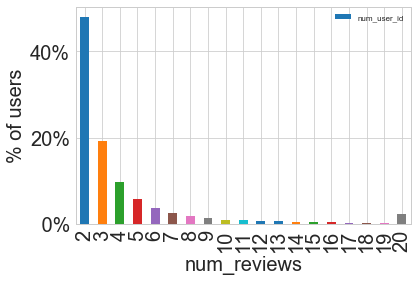

In [99]:
num_reviews_per_var(reviews, 'user_id', 'review_id', 20, 'num_reviews', '% of users')

This plot tells us that close to 45% of the users give us an average of 2 reviews on yelp. and around 4-5% gives us upto 20 reviews.

In [100]:
users = pd.read_csv('C:/Users/Jayanth Chava/Downloads/user_final.csv',encoding = "ISO-8859-1")


In [101]:
# displaying columns of user dataframe
user_ftres = [user_ftre for user_ftre in users.columns.tolist() if 'user_' in user_ftre]
user_ftres

['user_average_stars',
 'user_compliment_cool',
 'user_compliment_cute',
 'user_compliment_funny',
 'user_compliment_hot',
 'user_compliment_list',
 'user_compliment_more',
 'user_compliment_note',
 'user_compliment_photos',
 'user_compliment_plain',
 'user_compliment_profile',
 'user_compliment_writer',
 'user_cool',
 'user_fans',
 'user_funny',
 'user_review_count',
 'user_useful',
 'user_id',
 'user_elite_flag',
 'user_friends_flag']

In [102]:

y_user = 'user_average_stars'
user_compl_ftres = [ftre for ftre in user_ftres if 'user_compliment' in ftre]
user_count_ftres = ['user_cool', 'user_fans', 'user_funny', 'user_review_count', 'user_useful']
user_cat_ftres = ['user_elite_flag', 'user_friends_flag', 'yelping_since']

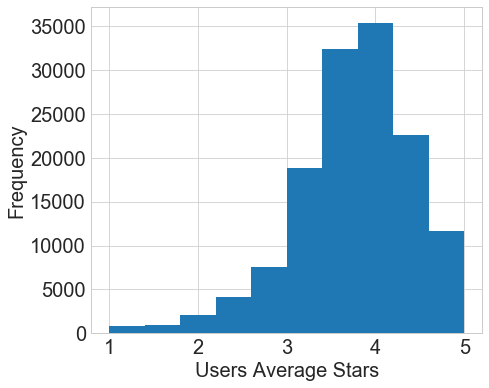

In [103]:
fig, ax = plt.subplots(1,1, figsize=(7, 6))
users[y_user].plot(kind='hist', ax=ax)
ax.set_xlabel('Users Average Stars')
plt.show()

This above plot shows us the average rating given by the users as you can see most users give a considerate rating of 4 stars

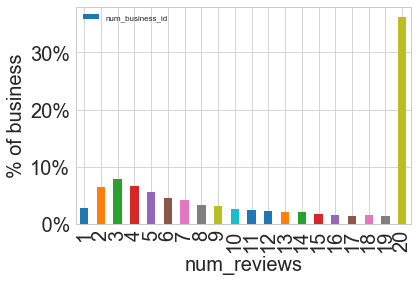

In [104]:
num_reviews_per_var(reviews, 'business_id', 'review_id', 20, 'num_reviews', '% of business')

this plot shows us that around 35% of the business have upto 20 reviews on yelp and around 5%-8% of the business have 2-4 reviews on yelp.  

# PCA - Principal Component Analysis


In real world data analysis tasks we analyze complex data i.e. multi dimensional data. We plot the data and find various patterns in it or use it to train some machine learning models. One way to think about dimensions is that suppose you have an data point x , if we consider this data point as a physical object then dimensions are merely a basis of view, like where is the data located when it is observed from horizontal axis or vertical axis.

As the dimensions of data increases, the difficulty to visualize it and perform computations on it also increases. So, how to reduce the dimensions of a data-
- Remove the redundant dimensions
- Only keep the most important dimensions

So what is PCA?

PCA finds a new set of dimensions (or a set of basis of views) such that all the dimensions are orthogonal (and hence linearly independent) and ranked according to the variance of data along them. It means more important principle
axis occurs first. 

<center>
<img src = /notebooks/images.ipynb/geometric-PCA-7-and-8-second-component-and-both-components.png width = 900 />
</center>

How does PCA work -

- Calculate the covariance matrix X of data points.
- Calculate eigen vectors and corresponding eigen values.
- Sort the eigen vectors according to their eigen values in decreasing order.
- Choose first k eigen vectors and that will be the new k dimensions.
- Transform the original n dimensional data points into k dimensions.

for better understanding of the topic 
http://setosa.io/ev/principal-component-analysis/

### Reducing the number of business categories
After expanding the business categories, we ended up with a dataframe of ~460 columns where each column was a distinct category. This number is too large, and we had to select categories that were more relevant to the goal of making recommendations to users. To find out which categories are most prominent and which are relevant for restaurant recommendation, we first got rid of the categories that only occur a few times in the dataset (the cutoff used was 11). These tended to be the ones not relevant to restaurants. Looking at the top 10 and bottom 10 categories in terms of number of occurrences, we found that the top 10 are mostly fast food or quick food places, and the bottom 10 are mostly ethnic food places. This gave us the idea that if two users like some of these rarely occurring restaurant categories, perhaps we could give them a greater weight when predicting/recommending the next restaurant. 

In [105]:
%%time
from sklearn.decomposition import PCA
sns.set_context('poster')
sns.set_style('white')
pd.set_option('display.max_columns', None)  

business_df = pd.read_csv('C:/Users/Jayanth Chava/Downloads/restaurants_final.csv', encoding='ISO-8859-1')

<string>:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.


Wall time: 5.57 s


In [106]:
busi_categories = ['Playgrounds',
       'Coffee & Tea', 'African', 'Jazz & Blues', 'Bagels', 'Coffeeshops',
       'Swimming Pools', 'Diners', 'Flea Markets', 'Fast Food', 'German',
       'Organic Stores', 'Dominican', 'Hot Dogs', 'Hotels & Travel',
       'Tea Rooms', 'Cheese Tasting Classes', 'Tasting Classes',
       'Gay Bars', 'Cupcakes', 'Art Classes', 'Beer Bar',
       'Coffee Roasteries', 'Cafeteria', 'Karaoke', 'Street Vendors',
       'Salad', 'Tapas/Small Plates', 'Poke', 'American (Traditional)',
       'Chocolatiers & Shops', 'Casinos',
       'Country Dance Halls', 'Public Markets', 'Financial Services',
       'Drive-Thru Bars', 'Armenian', 'Popcorn Shops',
       'Adult Entertainment', 'Pasta Shops', 'Bowling', 'South African',
       'Gift Shops', 'Persian/Iranian', 'Golf', 'Kosher',
       'Smokehouse', 'Basque', 'Landmarks & Historical Buildings',
       'Festivals', 'Amusement Parks', 'Eastern European', 'Gastropubs',
       'Do-It-Yourself Food', 'Puerto Rican', 
       'Creperies', 'New Mexican Cuisine', 'Wraps', 'Specialty Schools',
       'Fruits & Veggies', 'Japanese', 'British', 'Beer Garden',
       'Wineries', 'Arts & Crafts', 'Beer',
       'Wine & Spirits', 'Sandwiches', 'Fishmonger', 'Irish Pub',
       'Home Services', 'Social Clubs', 'Pop-up Shops', 'Polish',
       'Custom Cakes', 'Canadian (New)', 'Middle Eastern', 'Wine Bars',
       'Bistros', 'Hakka', 'Arcades', 'Halal', 'Trinidadian',
       'Turkish', 'Food Stands', 'Breakfast & Brunch', 'Hookah Bars',
       'CSA', 'Chicken Shop', 'Airports', 'Shopping Centers',
       'Soul Food', 'Meat Shops', 'Dim Sum', 'Pita', 'Tabletop Games',
       'Moroccan', 'Knife Sharpening', 'Cafes', 'Food Trucks', 'Shopping',
       'Acai Bowls', 'Spanish', 'Cheesesteaks', 'Churches', 'Hungarian',
       'Cambodian', 'Hawaiian', 'Australian', 'Delis', 'Szechuan',
       'Music Venues', 'Pub Food', 'Malaysian', 'Special Education',
       'Chicken Wings', 'Juice Bars & Smoothies', 'Bed & Breakfast',
       'Swiss Food', 'Dance Clubs', 'Kids Activities', 'Local Flavor',
       'Gun/Rifle Ranges', 'Asian Fusion',
       'Laser Tag', 'Vegetarian', 'Colombian', 'Laotian', 'Olive Oil',
       'Delicatessen', 'Poutineries', 'Teppanyaki', 'Resorts', 'Afghan',
       'Seafood Markets', 'Scottish', 'Shared Office Spaces',
       'Cajun/Creole', 'Champagne Bars', 'Peruvian', 'Speakeasies',
       'Bavarian', 'Food Delivery Services', 'Breweries',
       'Ice Cream & Frozen Yogurt', 'Tapas Bars', 'Tours',
       'Taiwanese', 'Food Court', 'Vegan', 'Cocktail Bars', 'Brasseries',
       'Desserts', 'Steakhouses', 'Community Service/Non-Profit',
       'Vitamins & Supplements', 'Mountain Biking', 'Sugar Shacks',
       'Lounges', 'French', 'Health Markets', 'Waffles',
       'Shaved Snow', 'Batting Cages', 'Sports Bars', 'Bakeries',
       'Beverage Store', 'Themed Cafes', 'Vietnamese',
       'Arts & Entertainment', 'Antiques', 'Czech', 'Cooking Schools',
       'Austrian', 'Patisserie/Cake Shop', 'Hong Kong Style Cafe', 'Ramen',
       'Mongolian', 'Shaved Ice', 'Tacos',
       'American (New)', 'Lebanese', 'Flowers & Gifts', 'Chinese',
       'Indian', 'Local Services', 'Ethnic Food', 'Himalayan/Nepalese',
       'Florists', 'Pizza', 'Club Crawl', 'Seafood', 'Argentine',
       'Tex-Mex', 'Brazilian', 'Egyptian', 'Sri Lankan',
       'Wine Tasting Room', 'Donuts', 'Wigs', 'Cuban', 'Active Life',
       'Salvadoran', 'Greek', 'Falafel',
       'Personal Shopping', 'Candy Stores', 'Pakistani', 'International',
       'Beer Gardens', 'Amateur Sports Teams', 'Gelato', 'Mosques', 'Pubs',
       'Comedy Clubs', 'Pool Halls', 'Southern', 'Imported Food',
       'Sushi Bars', 'Cheese Shops', 'Pan Asian', 'Bubble Tea',
       'Banks & Credit Unions', 'Education', 'Indonesian', 'Food Tours',
       'Coffee & Tea Supplies', 'Noodles', 'Fish & Chips', 'Kebab',
       'Milkshake Bars', 'Korean', 'Cabaret', 'Japanese Curry',
       'Farmers Market', 'Public Services & Government', 'Irish',
       'Latin American', 'Real Estate', 
       'Burgers', 'Wine Tours', 'Arabian', 'Buffets', 'Whiskey Bars',
       'Caribbean', 'Slovakian', 'Tuscan', 'Ukrainian', 'Distilleries',
       'Ethiopian', 'Izakaya', 'Barbeque',
       'Religious Organizations', 'Cantonese', 'Empanadas', 'Hot Pot',
       'Modern European', 'Internet Cafes', 'Kombucha', 'Nightlife',
       'Thai', 'Bangladeshi', 'Bars', 'Venezuelan', 'Dive Bars', 'Fondue',
       'Guest Houses', 'Mediterranean', 'Belgian', 'Portuguese', 'Donairs',
       'Russian', 'Herbs & Spices', 'Mexican', 'Macarons', 'Cinema',
       'Butcher', 'Filipino', 'Pretzels', 'Reunion', 'Live/Raw Food',
       'Mini Golf', 'Scandinavian', 'Burmese', 'Yelp Events',
       'Specialty Food', 'Couriers & Delivery Services', 'Soup',
       'Singaporean', 'Comfort Food', 'Museums', 'Italian']

Calculating each categories count in the dataframe

In [108]:
num_busi_cat = business_df[busi_categories].sum()
# only consider those with total counts greater than 11
num_busi_cat = num_busi_cat[num_busi_cat > 11]
num_busi_cat.sort_values(axis=0, ascending=False, inplace=True)
num_busi_cat = num_busi_cat.reset_index()
num_busi_cat.columns = ['category', 'count']
print(num_busi_cat)

                      category  count
0                    Fast Food   6530
1                   Sandwiches   3335
2                 Coffee & Tea   2883
3                      Burgers   2692
4                         Bars   2133
5           Breakfast & Brunch   1846
6                        Cafes   1709
7                    Nightlife   1358
8                     Desserts   1292
9                      Mexican   1253
10              Specialty Food   1227
11                    Bakeries   1191
12                       Pizza   1001
13               Chicken Wings    847
14                       Salad    814
15                        Beer    808
16                       Delis    805
17   Ice Cream & Frozen Yogurt    803
18              Wine & Spirits    733
19                     Chinese    701
20                Comfort Food    694
21      Juice Bars & Smoothies    640
22                     Italian    629
23                 Ethnic Food    543
24      Food Delivery Services    495
25          

In [114]:
len(num_busi_cat) # these are the total number of categories taken into consideration before running PCA algorithm

158

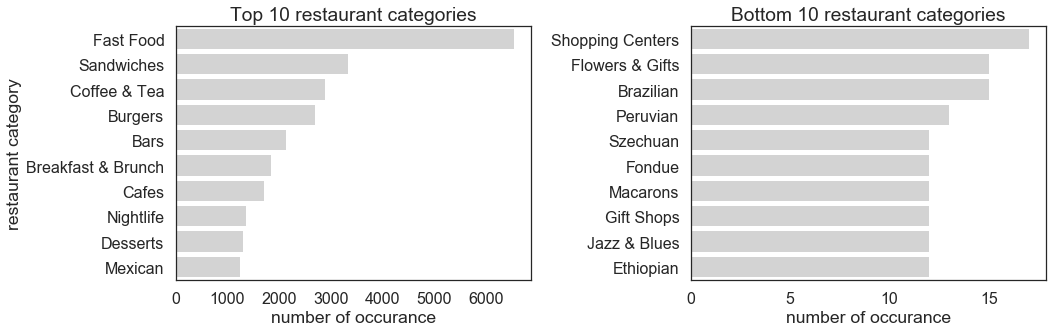

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x='count', y='category', data=num_busi_cat.head(10), color='lightgrey', ax=ax[0])
ax[0].set(ylabel='restaurant category')
ax[0].set(xlabel='number of occurance')
ax[0].set(title='Top 10 restaurant categories')
sns.barplot(x='count', y='category', data=num_busi_cat.tail(10), color='lightgrey', ax=ax[1])
ax[1].set(xlabel='number of occurance')
ax[1].set(title='Bottom 10 restaurant categories')
ax[1].set(ylabel='')
plt.tight_layout()
plt.show()

these plots tell us that fastfood restaurants are abundant in the yelp database close to 6000 such establishments, jazz & blues and gift shops are amongst the least in occurence around 12 such businesses.

### Restaurant categories can be further reduced to a smaller set of dimensions. 
After getting rid of the categories that only occur a few times in the dataset, we still had ~180 restaurant categories. While this number is smaller than the original we started with (~460), we sought to further reduce the number by performing dimensionality reduction (specifically, PCA). By doing so, we obtained the first 30 principal components that explained ~75% of the total variance in the data. Looking at the first 3 PCs for visualization, we found that the top three categories (fast food, sandwiches, and coffee & tea) are nicely clustering in these spaces. Given these results, we think that dimensionality reduction could be a useful way to incorporate many features related to restaurants for finding similar restaurants in the recommendation system. 


In [111]:

n_components = 30
pca = PCA(n_components=n_components)

tokeep = list(num_busi_cat['category'].values) + ['business_id']
print(tokeep)

['Fast Food', 'Sandwiches', 'Coffee & Tea', 'Burgers', 'Bars', 'Breakfast & Brunch', 'Cafes', 'Nightlife', 'Desserts', 'Mexican', 'Specialty Food', 'Bakeries', 'Pizza', 'Chicken Wings', 'Salad', 'Beer', 'Delis', 'Ice Cream & Frozen Yogurt', 'Wine & Spirits', 'Chinese', 'Comfort Food', 'Juice Bars & Smoothies', 'Italian', 'Ethnic Food', 'Food Delivery Services', 'Food Trucks', 'Seafood', 'Bagels', 'Tex-Mex', 'Asian Fusion', 'Hot Dogs', 'Chicken Shop', 'Barbeque', 'Mediterranean', 'Japanese', 'Vegetarian', 'Pubs', 'Soup', 'Soul Food', 'Food Stands', 'Imported Food', 'Diners', 'Vegan', 'Breweries', 'Middle Eastern', 'Sports Bars', 'Sushi Bars', 'Wine Bars', 'Southern', 'Donuts', 'Indian', 'Cocktail Bars', 'Thai', 'Arts & Entertainment', 'Steakhouses', 'French', 'Street Vendors', 'Bubble Tea', 'Tea Rooms', 'Greek', 'Vietnamese', 'Food Court', 'Creperies', 'Gastropubs', 'Poke', 'Taiwanese', 'Halal', 'Hawaiian', 'Korean', 'Lounges', 'Caribbean', 'Latin American', 'Beer Bar', 'Meat Shops', 'T

These are the categories of establishments that we want to keep in our dataframe to build our recommendation engine 

In [112]:
business_df_sub = business_df[tokeep]
X = business_df_sub.drop(axis=1, inplace=False, labels=['business_id'])
print(X)


       Fast Food  Sandwiches  Coffee & Tea  Burgers   Bars  \
0          False       False         False    False  False   
1          False       False         False    False  False   
2           True       False         False     True  False   
3          False       False          True    False  False   
4           True        True         False    False  False   
5          False       False         False    False  False   
6           True       False         False    False  False   
7          False       False          True    False  False   
8          False        True         False    False  False   
9           True        True         False    False  False   
10         False       False         False    False  False   
11         False       False         False    False  False   
12         False       False          True    False  False   
13         False       False          True    False  False   
14          True       False         False     True  False   
15      

The above dataframe tells us which business serve which categories of food items

In [113]:
X_pca = pca.fit_transform(X)
print(X_pca)


[[ 2.55065371e-01  1.43694258e-01 -9.38728596e-02 ...  3.68497228e-02
  -2.87920066e-01 -1.48904601e-01]
 [ 3.07672246e-01 -1.05095859e-01 -2.71957232e-03 ... -3.55322895e-02
  -3.78257683e-02 -3.74240756e-02]
 [-8.79414152e-01  2.13835783e-01  4.31403232e-01 ...  2.00073176e-02
   1.95081602e-02 -6.47508206e-02]
 ...
 [-6.09040108e-01 -2.88393994e-01 -6.70756904e-01 ... -1.20958352e-02
  -5.86077674e-03 -3.81008743e-02]
 [ 4.82446304e-01 -1.21238084e-01 -7.24642015e-02 ... -5.47244050e-02
   4.03180168e-03 -6.71396682e-02]
 [-6.20547463e-01  1.47122041e-01 -2.43787038e-02 ... -5.09630625e-03
   3.40278651e-04 -3.26500429e-02]]


The above line returns Fit the model with X and apply the dimensionality reduction on X.


<html>
<head>
<title>Page Title</title>
</head>
<body>

<h1>DEVELOPING A SCREE PLOT </h1>
<p>what is a scree plot?</p>
</p>A Scree Plot is a simple line segment plot that shows the fraction of total variance in the data as explained or represented by each PC. The PCs are ordered, and by definition are therefore assigned a number label, by decreasing order of contribution to total variance.</p>

</body>
</html>

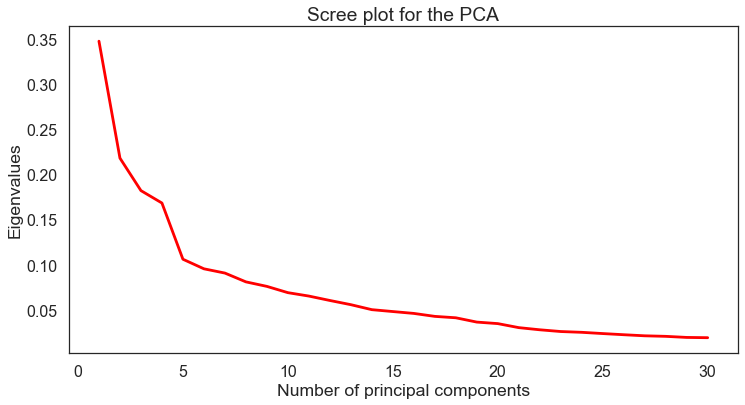

In [116]:

# # we make a scree plot to see how many Principal Components to consider
plt.figure(figsize=(12, 6))
eig = pca.explained_variance_

# # and calculate the variance explained by the PC analysis
var_exp = pca.explained_variance_ratio_.cumsum()*100.

plt.plot(np.arange(1,len(eig)+1), eig, color='r')
plt.title('Scree plot for the PCA')
plt.xlabel('Number of principal components')
plt.ylabel('Eigenvalues')
plt.show()

we hope to cover atleast 70% of the variance in the dataset

In [117]:
v = var_exp[-1] # calculating variance 
print("% variance explained by keeping 30 PCs:", v)

% variance explained by keeping 30 PCs: 77.75614981091236


In [118]:
# this function directly plots the principal component analysis 
def plot_pca_results(pc1, pc2, feature_name):
    temp = pd.DataFrame([])
    temp['pc1'] = X_pca[:,pc1]
    temp['pc2'] = X_pca[:,pc2]
    temp['f'] = business_df_sub[feature_name]
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.plot(temp[temp['f'] == False]['pc1'], temp[temp['f'] == False]['pc2'], 'o', label='no', alpha=0.5)
    ax.plot(temp[temp['f'] == True]['pc1'], temp[temp['f'] == True]['pc2'], 'o', label='yes', alpha=0.5, color='brown')
    ax.set(title=feature_name)
    ax.set(xlabel='principle component ' + str(pc1+1))
    ax.set(ylabel='principle component ' + str(pc2+1))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

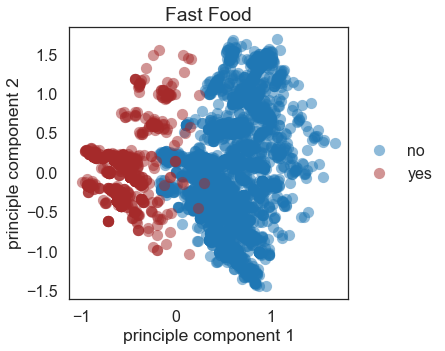

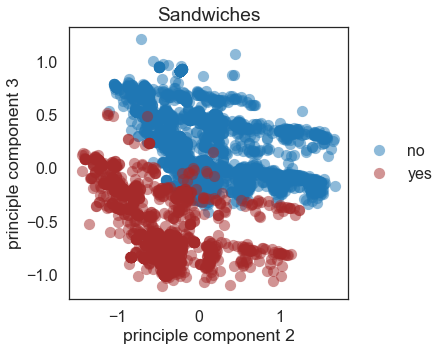

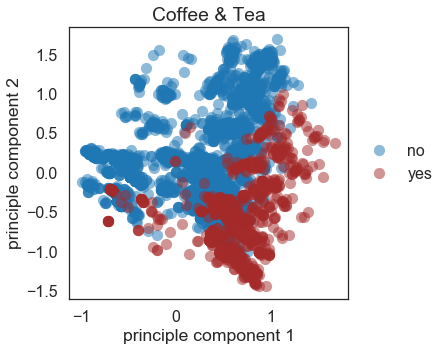

Wall time: 4.71 s


In [119]:
%%time
feature_name = 'Fast Food'
plot_pca_results(0, 1, feature_name)
feature_name = 'Sandwiches'
plot_pca_results(1, 2, feature_name)
feature_name = 'Coffee & Tea'
plot_pca_results(0, 1, feature_name)

# Recommendation filtering techniques
The use of efficient and accurate recommendation techniques is very important for a system that will provide good and useful recommendation to its individual users. This explains the importance of understanding the features and potentials of different recommendation techniques. Fig. below shows the anatomy of different recommendation filtering techniques.

## Content-based filtering
Content-based technique is a domain-dependent algorithm and it emphasizes more on the analysis of the attributes of items in order to generate predictions. When documents such as web pages, publications and news are to be recommended, content-based filtering technique is the most successful. In content-based filtering technique, recommendation is made based on the user profiles using features extracted from the content of the items the user has evaluated in the past. Items that are mostly related to the positively rated items are recommended to the user.

## Collaborative filtering
Collaborative filtering is a domain-independent prediction technique for content that cannot easily and adequately be described by metadata such as movies and music. Collaborative filtering technique works by building a database (user-item matrix) of preferences for items by users. It then matches users with relevant interest and preferences by calculating similarities between their profiles to make recommendations . Such users build a group called neighborhood. An user gets recommendations to those items that he has not rated before but that were already positively rated by users in his neighborhood.

papers reffered
-(https://cambridgespark.com/content/tutorials/implementing-your-own-recommender-systems-in-Python/index.html)
-(https://towardsdatascience.com/how-to-build-a-simple-song-recommender-296fcbc8c85)

Further, there are several types of collaborative filtering algorithms :
- User-User Collaborative filtering:

Here we find look alike customers (based on similarity) and offer products which first customer’s look alike has chosen in past. This algorithm is very effective but takes a lot of time and resources. It requires to compute every customer pair information which takes time. Therefore, for big base platforms, this algorithm is hard to implement without a very strong parallelizable system.

<center>
<img src = /notebooks/images.ipynb/User-based-collaborative-filtering-algorithm.png width = 500 />
</center>

- Item-Item Collaborative filtering:

It is quite similar to previous algorithm, but instead of finding customer look alike, we try finding item look alike. Once we have item look alike matrix, we can easily recommend alike items to customer who have purchased any item from the store. This algorithm is far less resource consuming than user-user collaborative filtering. Hence, for a new customer the algorithm takes far lesser time than user-user collaborate as we don’t need all similarity scores between customers. And with fixed number of products, product-product look alike matrix is fixed over time.

<center>
<img src = /notebooks/images.ipynb/item-to-item.png width = 500 />
</center>

- User-item Collaborative filtering:

Here we find items that the users has previously shown intrest in or bought and find similar items from the same category or domain 

<center>
<img src = /notebooks/images.ipynb/user-to-item.png width = 500 />
</center>

<center>
<img src = /notebooks/images.ipynb/useritemmatrix.png width = 500 />
</center>

- Model-Based Collaborative filtering

Because there is not a huge overlap between all users and all restaurants, we observed that our dataframe is very sparce (>99.9%), as expected. Given this sparsity, we also implemented model-based CF that is able to deal with sparsity better than memory-based CF. Other drawbacks to memory-based CF include 1) lack of scalability and 2) cold-start problem. Cold-start problem means that it is not possible to make predictions for new users or restaurants that has no previous rating at all. Model-based collaborative filtering can handle higher sparsity levels and is more scalable, but also suffer from the cold-start problem.

The way the model-based collaborative filtering handles high sparsity is through dimensionality reduction and latent variable decomposition. Although we only have the users' ratings for businesses as the dataset, underlying this data are the hidden preferences of users for certain businesses because of their hidden attributes. These latent variables are learned by the model-based CF. To do this, we used matrix factorization, which provides the latent vectors and allows filling in the sparse, original matrix: it predicts unknown ratings by taking the dot product of the latent features of users or items. For implementing matrix factorization, we used singular value decomposition (SVD). SVD is solved as follows:

X=U∗S∗V(T)
X=U∗S∗V(T)
 
Where:

X represents an m x n matrix
U represents the m x r orthogonal matrix
S represents the r x r diagonal matrix with non-negative real numbers on the diagonal
V(T)V(T)  represents the r x n orthogonal matrix
Elements on the diagonal of S are known as singular values of X
Matrix X can be factorized into U, S, and V.

U represents the feature vectors corresponding to users in the hidden feature space
V represents the feature vectors corresponding to items in the hidden feature space
Finally, we make our prediction by taking the dot product of U, S, and  V(T)V(T) .

#  Model evaluation
To maintain compatibility with results published by others implementation of recommendation systems, we are going to adopt the standard set by the Netflix prize and the quality of our results will be measured using the root mean squared error (MSE). 

$${\mathit{R}\mathit{M}\mathit{S}\mathit{E}} = \sqrt{\frac{1}{N}\sum(x_{i} - \hat{x_{i}})^{2}}$$

That measure puts more emphasis on large errors compared with the alternative of mean absolute error. 

In [121]:
### Pre-collaborative filtering step: Organize data into a table with users and businesses' ratings as two columns.

import numpy as np
import pandas as pd
from sklearn import cross_validation as cv
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from sklearn.model_selection import KFold
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

C:\Users\Jayanth Chava\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Due to memory issues we had to limit the size of the train and test data. This obviously greatly affects the precision and ability of our recommendation system to recommend the perfect restaurant to our users.

In [122]:
df = pd.read_csv('C:/Users/Jayanth Chava/Downloads/recommendations.csv',encoding = "ISO-8859-1",index_col=0)
sample_df = pd.read_csv('C:/Users/Jayanth Chava/Downloads/sample.csv',encoding = "ISO-8859-1",index_col=0) 
sample_df = sample_df[0:20001] # decreasing for 56,000 columns to 20,000 columns for memory purposes.


C:\Users\Jayanth Chava\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (20,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Jayanth Chava\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [123]:
"""
add_numerical_id()
-this function replaces string identifiers with numeric identifiers


inputs: dataframe, variable to be replaced, name of new variable
outputs: dataframe with new variables
"""
def add_numerical_id(df, var, new_var):
    # Get the list of Later, we'll change the user_id and business_id by numerical values
    unique_values = df[var].unique()
    n_unique_values = len(unique_values)
    df_var_id = pd.DataFrame(data=unique_values, index=range(0,n_unique_values), columns=[var])
    df_var_id.index.name = new_var
    df_var_id.reset_index(drop=False, inplace=True)
    df = df.merge(df_var_id, how='left', on=var)
    return df

In [124]:
"""
create_dummy_var()
--this function creates dummy variables and appends them to the dataframe


inputs: dataframe, list of variables to create dummy variables
outputs: updated dataframe, list of dummy variables that were created

"""
def create_dummy_var(df, list_vars):
    list_dummy_var = []
    for var in list_vars:
        dummy_vars = pd.get_dummies(df[var], prefix=var, drop_first=True)
        df = df.merge(dummy_vars, how='left', left_index=True, right_index=True)  
        list_dummy_var.extend(dummy_vars.columns.values)
    return df, list_dummy_var

populating the sample dataframe with User Id's

In [125]:
%%time

cat_ftres = ['is_open', 'state', 'Fast Food', 'Sandwiches', 'Coffee & Tea',
             'Burgers', 'user_elite_flag', 'user_friends_flag']

df, ftres_dummy = create_dummy_var(df, cat_ftres)
sample_df, sample_ftres_dummy = create_dummy_var(sample_df, cat_ftres)

df = add_numerical_id(df, 'user_id', 'user_id_key')
df = add_numerical_id(df, 'business_id', 'business_id_key')



sample_df = add_numerical_id(sample_df, 'user_id', 'user_id_key')
sample_df = add_numerical_id(sample_df, 'business_id', 'business_id_key')


Wall time: 13.2 s


calculating the total number of users in the sample dataframe

In [126]:
n_users = df['user_id'].unique().shape[0]
n_items = df['business_id'].unique().shape[0]

sample_n_users = sample_df['user_id'].unique().shape[0]
sample_n_items = sample_df['business_id'].unique().shape[0]
print(n_users, n_items)
print(sample_n_users, sample_n_items)




136368 16037
7109 6824


Creating unique User ID's with their corresponding average rating

In [127]:
%%time

#create a unique list of user_id_keys and their corresponding average rating
user_id_key_rating = df.groupby('user_id_key')['user_average_stars'].max()
user_rating_count = df.groupby('user_id_key')['user_average_stars'].count()
user_highest_index = df.groupby('user_id_key',sort=False)['review_stars'].idxmax()
business_by_index = df.loc[user_highest_index,'business_id_key']
user_highest_rated_restaurant = pd.Series(data=business_by_index.values,
          index=user_highest_index.index)

#create a unique list of business_id_keys and their corresponding business name
business_id_key_name = df.groupby('business_id_key')['name'].max()

#other features to be included in the model:
ftres_response = ['review_stars']
ftres_ids = ['user_id_key', 'business_id_key']
ftres_all = ftres_ids + ftres_response

Wall time: 19.6 s


In [129]:
#df = df[ftres_all]
sample_df = sample_df[ftres_all] # adding these columns to the sample dataframe

In [131]:
#algorithm to create a matrix
"""
create_matrix()

-transforms a dataframe into a user-item matrix

inputs: dataframe, number of users, number of items
outputs: user-item matrix

"""
def create_matrix(df, n_users, n_items):
    matrix = np.zeros((n_users,n_items))
    
    for line in df.itertuples():     
        
        matrix[line[1]-1, line[2]-1] = line[3]
    
    return matrix

splitting the data into test and train dataframes , and then creating train and test matrix 

In [132]:
%%time
#train, test = cv.train_test_split(df, test_size=0.25) #split dataframe into train/test
sample_train, sample_test = cv.train_test_split(sample_df, test_size=0.25)

#train_matrix = create_matrix(train, n_users, n_items)
#test_matrix = create_matrix(test, n_users, n_items)

sample_train_matrix = create_matrix(sample_train, sample_n_users, sample_n_items)
sample_test_matrix = create_matrix(sample_test, sample_n_users, sample_n_items)

#print(train_matrix.shape)
print(sample_train_matrix.shape)

(7109, 6824)
Wall time: 942 ms


In [133]:
sample_train_matrix

array([[3., 0., 0., ..., 0., 0., 0.],
       [0., 3., 3., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 4., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

calculating the pairwise distances using cosine function
This is done to check the pairwise distance between different items so that we can run item - item Collaborative filtering 

In [134]:
%%time
sample_user_similarity = pairwise_distances(sample_train_matrix, metric='cosine')
sample_item_similarity = pairwise_distances(sample_train_matrix.T, metric='cosine')

Wall time: 12.3 s


In [135]:
"""
memory_based_prediction()

-uses the cosine similarity to make predictions for user-item ratings

inputs: ratings matrix, cosine similarity, flag to account for biases
outputs: predictions for user-item ratings

"""

def memory_based_prediction(ratings, similarity, bias=False):
    if bias: #account for biases for users
        mean_user_rating = ratings.mean(axis=1)
        bias = (ratings-mean_user_rating[:,np.newaxis])
        prediction = mean_user_rating[:,np.newaxis] + similarity.dot(bias) / np.array([np.abs(similarity).sum(axis=1)]).T
    else:
        prediction = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        
    return prediction

here , we are running the memory based prediction

In [136]:
%%time
sample_item_prediction = memory_based_prediction(sample_train_matrix, sample_item_similarity)
sample_user_prediction = memory_based_prediction(sample_train_matrix, sample_user_similarity, bias=True)

Wall time: 19.2 s


creating the function for calculating RMSE of both the collobrative filtering

In [138]:
"""
rmse()
-computes the root mean squared error for a models' predictions

inputs: rating prediction, actual rating
outputs: random mean squared error

"""

def rmse(y, y_hat):
    y_hat = y_hat[y.nonzero()].flatten() #only consider predicted ratings that are in the dataset
    y = y[y.nonzero()].flatten()
    rmse = sqrt(mean_squared_error(y_hat, y))
    return rmse

In [139]:

print("user-item based collaborative filtering RMSE: ", rmse(sample_test_matrix,sample_user_prediction)) 
print("item-item based collaborative filtering RMSE: ", rmse(sample_test_matrix,sample_item_prediction)) 

user-item based collaborative filtering RMSE:  3.9269923315663515
item-item based collaborative filtering RMSE:  3.929015408326366


We see that the item-based prediction model is slightly more accurate than the user-based prediction model.

# Model-based Collaborative Filtering

Because there is not a huge overlap between all users and all restaurants, we observed that our dataframe is very sparce (>99.9%), as expected. Given this sparsity, we also implemented model-based CF that is able to deal with sparsity better than memory-based CF. 

In [140]:
sparsity=round(1.0-len(df)/float(n_users*n_items),10)
print("percent sparsity = ", sparsity) 

percent sparsity =  0.9997233153


creating a function for Single value decomposition 

In [142]:
"""
SVD_prediction()
-uses singular value decomposition to make rating predictions

inputs: matrix, number of singular values and vectors to compute
output: prediction through SVD

"""

def SVD_prediction(matrix, k_size):
    u, s, vt = svds(matrix, k = k_size) #create matrices described above
    s_diag_matrix=np.diag(s) #take diagonal matrix of S
    prediction = np.dot(np.dot(u, s_diag_matrix),vt) #prediction is the dot product of u, s, and vt
    
    return prediction

In [143]:
sample_train.shape

(15000, 3)

We are running our SVD prediction function only on the sample dataframe as the system crashes when I run it on X_pred.

In [144]:
%%time
#X_pred = SVD_prediction(train_matrix, 100)
sample_X_pred = SVD_prediction(sample_train_matrix, 100)
print(rmse(sample_X_pred, sample_test_matrix))

0.04807493348671061
Wall time: 28 s


creating a matrix of our sample dataframe and sample users and sample items

In [145]:
%%time
# filter the data to get rid of restaurants that a user has been to already
entire_matrix = create_matrix(sample_df, sample_n_users, sample_n_items)

Wall time: 39.9 ms


In [148]:
sample_n_users # due to memory constrains our recommendation engine is limited to 7109 users

7109

In [147]:
%%time
sample_entire_matrix = create_matrix(sample_df,sample_n_users, sample_n_items)
sample_entire_item_similarity = pairwise_distances(sample_entire_matrix.T, metric='cosine')

Wall time: 6.14 s


In [150]:
sample_entire_matrix.shape

(7109, 6824)

In [151]:
"""
similar_businesses()
-function essentially works as a k-NN function using the pairwise distance matrix

-this function filters out non-ratings by filtering out any cosine similarities of 1.0. The idea is that
 a similarity of 1.0 is highly unlikely unless it is as a result of pure non-ratings. The sophistication of this function would
 be an area of improvement if we had more time on this assignment
 
inputs: list of businesses, 

"""
def similar_businesses(businesses,similarity_matrix,k):
    closest = np.zeros((n_items,k))
    for business in businesses:
        all_businesses = similarity_matrix[business,:]
        mask = all_businesses < 1
        closest[business]=np.where(mask, all_businesses, np.nanmin(all_businesses)).argsort()[-k:][::-1]
    return closest    

creating a business similarity matrix this is essentially a matrix of recommendations 

In [152]:
%%time
business_similarity_matrix = similar_businesses(sample_df['business_id_key'].unique(),sample_entire_item_similarity,3)
business_similarity_matrix

Wall time: 2.73 s


In [154]:

def restaurant_recommender(user):
    #figure out which users the restaurant has already rated
    restaurants_rated = entire_matrix[user,:].nonzero()

    if user_rating_count[user] <= 10:#if the user has less than 10 ratings, we will use any predictions from the SVD model
        mask = sample_X_pred[user,:] >= 1.0 #a predicted rating of less than 1.0 means we have an invalid prediction
    else:#if the user has 10 ratings, we will only recommend restaurants that have a predicted rating higher than the user's average
        mask = sample_X_pred[user,:] >= user_id_key_rating[user]
    restaurant_predictions = np.where(mask)

     #remove already-rated restaurants from possible restaurant recommendations
    recommendations = np.setdiff1d(restaurant_predictions,restaurants_rated)
    
    n_SVD_recommendations = recommendations.shape[0]
    
    if n_SVD_recommendations >=3: #if we can give 3 recommendations from SVD, we will do that
        listOfIndices = list(recommendations)
        top3Indices = sample_X_pred[user,recommendations].argsort()[-3:][::-1]
        final_recommendation = [listOfIndices[i] for i in top3Indices]
        #last, we convert the business_id_key to the business name
        return list(business_id_key_name[final_recommendation].values)
    
    elif n_SVD_recommendations >=1: #if we can't give 3 recommendations, but can give 1, that will be our first recommendation
        listOfIndices = list(recommendations)
        top_n_Indices = sample_X_pred[user,recommendations].argsort()[-n_SVD_recommendations:][::-1]
        final_recommendation = [listOfIndices[i] for i in top_n_Indices]
    else: #if no SVD predictions, create an empty list to append to
        final_recommendation = []
    
    #find restaurants similar to that user's highest rated restaurant
    highest_rated_restaurant = user_highest_rated_restaurant[user]
    similar_to_highest_rated = list(business_similarity_matrix[highest_rated_restaurant].astype(int))
    
    #add these similar restaurants to the recommendation list until we have 3 total recommendations
    for i in range(3-n_SVD_recommendations):
        final_recommendation.append(similar_to_highest_rated[i])
    #last, we convert the business_id_key to the business name
    return list(business_id_key_name[final_recommendation].values)

In [157]:
%%time
# for user no. 6

restaurant_recommender(6)

Wall time: 241 ms


['Golden Restaurant and Bakery',
 'Little Sheep Mongolian Hot Pot',
 'Eggspectation']

In [158]:
# for user no. 6000
restaurant_recommender(6000)

['Java Cat', 'Distill - A Local Bar', 'Mabu Station']

In [159]:
# for user no. 977
restaurant_recommender(977)


['Zav Coffee Shop & Gallery', 'Easy Life Boba Tea', "Lou Malnati's Pizzeria"]

In [161]:
restaurant_recommender(7108)# this is the last user in our recommendation system the user 7109 doesnt exist.

['Pho Avina', 'Juice NV', 'Bar Code Burger Bar']

# Conclusions and Future Work

The drawback to SVD is that it only makes predictions for ~10% of users, meaning that an ensemble method is required to make predictions using an SVD model. Another drawback to our SVD model is that it just makes a prediction; there are no coefficients, which makes interpretability of features difficult. 

If given more time, we would revisit the cosine similarity functions. It seems that these functions failed because there are such a large amount of users. If we were able to filter to a subset of the most important users for any given business, we would be able to reduce the size of this matrix and make a more accurate similarity model as a result. However, this approach would be limited to only those users who are active in Yelp. 

# Results 

from our regularized regression could also likely be improved if we spent more time determining what the most important categorical features were. Lastly, another avenue for improvement would be to incorporate the regularized user bias and restaurant bias into our collaborative filtering models so that it increases the interpretability and the number of predictable users. Such hybrid approach would also address the cold-start problem(new user no reviews or ratings). Our data exploration work clearly showed that there are relationships between restaurant attributes, thus it would be a great addition to the Collabrative filter models to improve predictability. 

The total runtime of this code was close to 2 and a half hours for me. Our implementation of recommendation systems was far from perfect in our opinion, but this project helped us get a better understanding of many concepts, and could also help in our future endeavours. 